# **CIS 5450 Final Project - VC Success Prediction**
*Akhilesh, Renyi, Andrew*
*Dec., 2023*

#Part 1: Introduction and Context
For our final project, we want to understand the enviornment, trends, and factors that influenced startup success, both from a Venture Capital investor's perspective in being able to make informed investment decisions regarding startups and from a founder's perspective in starting a new company. We believe that a thorough analysis and understanding of the startup environment is critical to success in the area. Our data source is outlined below, though more information regarding the specifics of our dataset is outlined in later parts.

The dataset we used is called "Startup Investments", published by Justinas Cirtautas on [Kaggle](https://www.kaggle.com/datasets/justinas/startup-investments). This dataset was built by aggregating data from Crunchbase. This dataset contained 11 seperate 'datasets' (tables), which are outlined in more detail later.

#Part 2: Imports

First, we import a variety of packages to facilitate our project. Among these include packages for handling data, plotting, and creating and tuning models.

In [ ]:
# common packages
import warnings
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime

# EDA
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# oversampling
from imblearn.over_sampling import SMOTE

# scikit-learn packages
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# lightgbm
from lightgbm import LGBMClassifier

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

drive.mount('/content/drive')
warnings.filterwarnings("ignore")
seed = 2    # set random seed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/Shareddrives/cis545/Data

/content/drive/Shareddrives/cis545/Data


#Part 3: Data Cleaning

## 3.1 Loading Data

### 3.1.1 Creating Dataframes

Our dataset spans 11 dataframes spanning topics from fundamentals of the startup companies to the details of the key people involved in these startups. We have a 12th dataframe that lists the recessions that we have had since the start of the startup data. This will be used to analyze economic conditions when the startups were started.<br><br>
We will import these dataframes using Pandas.

In [ ]:
#import Startups Dataset dfs
relationships_df = pd.read_csv('relationships.csv')
people_df = pd.read_csv('people.csv')
offices_df = pd.read_csv('offices.csv')
objects_df = pd.read_csv('objects.csv', low_memory=False)
milestones_df = pd.read_csv('milestones.csv')
ipos_df = pd.read_csv('ipos.csv')
investments_df = pd.read_csv('investments.csv')
funds_df = pd.read_csv('funds.csv')
funding_rounds_df = pd.read_csv('funding_rounds.csv')
degrees_df = pd.read_csv('degrees.csv')
acquisitions_df = pd.read_csv('acquisitions.csv')

#import recessions dataset
recessions_df = pd.read_csv('USREC.csv')

Given the large number of datasets we have imported, we have a lot of merging and cleaning to do!

### 3.1.2 Analyzing Data Structure

The fundamental information about the startups is contained in objects_df. So, we will examine the columns, data types, and values in this dataframe.


In [ ]:
objects_df.head(5)

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,...,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,...,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18


View the columns and schema, count the number of non null entries in each column.

In [ ]:
objects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462651 entries, 0 to 462650
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   462651 non-null  object 
 1   entity_type          462651 non-null  object 
 2   entity_id            462651 non-null  int64  
 3   parent_id            27715 non-null   object 
 4   name                 462649 non-null  object 
 5   normalized_name      462620 non-null  object 
 6   permalink            462651 non-null  object 
 7   category_code        123186 non-null  object 
 8   status               462651 non-null  object 
 9   founded_at           100441 non-null  object 
 10  closed_at            2809 non-null    object 
 11  domain               174942 non-null  object 
 12  homepage_url         174942 non-null  object 
 13  twitter_username     126089 non-null  object 
 14  logo_url             208850 non-null  object 
 15  logo_width       

### 3.1.3 Filtering Entity Types

This dataframe has multiple entity types. Since we are only interested in companies at the moment, we will filter the dataset down before further operations. We can do this because the entity_type column has no null values. So, we will get all the entity types contained in the data, and count the number of entries for each.

In [ ]:
objects_df['entity_type'].value_counts()

Person          226708
Company         196553
Product          27738
FinancialOrg     11652
Name: entity_type, dtype: int64

Due to the presence of multiple entity types in our data, it is hard to do any immiedate measures of central tendency and range, as this would be like comparing apples to oranges. We must first standardize and prepare out data.

### 3.1.4 Creating companies_df

We have over 196,000 companies. We will first filter these out from the rest. We save the results in companies_df.

In [ ]:
companies_df = objects_df[objects_df['entity_type'] == 'Company']

We will check the number of number of non-null entries for each column again. Then we can start dropping columns and treating the null values.

In [ ]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196553 entries, 0 to 196552
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   196553 non-null  object 
 1   entity_type          196553 non-null  object 
 2   entity_id            196553 non-null  int64  
 3   parent_id            0 non-null       object 
 4   name                 196553 non-null  object 
 5   normalized_name      196549 non-null  object 
 6   permalink            196553 non-null  object 
 7   category_code        123186 non-null  object 
 8   status               196553 non-null  object 
 9   founded_at           91227 non-null   object 
 10  closed_at            2620 non-null    object 
 11  domain               126545 non-null  object 
 12  homepage_url         126545 non-null  object 
 13  twitter_username     80591 non-null   object 
 14  logo_url             110110 non-null  object 
 15  logo_width       

Examine the data to determine the number of unique values in each column.

In [ ]:
companies_df.nunique()

id                     196553
entity_type                 1
entity_id              196553
parent_id                   0
name                   196506
normalized_name        195685
permalink              196512
category_code              42
status                      4
founded_at               6156
closed_at                 925
domain                 125498
homepage_url           125961
twitter_username        79571
logo_url               110110
logo_width               3326
logo_height              2129
short_description        7128
description             83741
overview               126876
tag_list                79133
country_code              175
state_code                 51
city                    10727
region                   5865
first_investment_at      1197
last_investment_at       1105
investment_rounds          42
invested_companies         38
first_funding_at         3208
last_funding_at          2978
funding_rounds             16
funding_total_usd        9721
first_mile

Here, it is apparent that we have some consistencies among our data (at least in the type of object the data represents).

## 3.2 Dropping Insignificant Columns and Null Values

We will now drop a few columns for the following reasons:<br>

`entity_type`: Now they are all 'Company,' so after filtering, this column is not necessary. <br>
`parent_id`: This column has 0 non-null values. <br>
`normalized_name`: We already have the `name` column, do this one does not provide any new information. It also has fewer values.<br>
`Permalink`: This refers to the crunchbase URL, not any fundamental information about the company. It also could not provide helpful information regarding the company's performance or be assesed quantitatively from a baseline. <br>
`closed_at`: This information is not relevant to our project, since we only want the `status` of the company to predict whether or not the company succeeded. <br>
`Domain, homepage_url, twitter_username, logo_url, logo_width, logo_height`: These columns contain extraneous information, and do not present useful features. While these factors may have an impression on customers and VCs, these are not easy to quantify.<br>
`short_description, description, overview`: We will drop these columns because it would be difficult to convert them into meaningful numerical or categorical features without Natural Language Processing.<br>
`city, region`: There have an extremely high number of unique values, and creating clean categorical variables would not be easy.<br>
`first_investment_at, last_investment_at, investment_rounds, invested_companies, first_funding_at, last_funding_at`: Very few companies have nonzero values for these columns We will focus on the number of funding rounds instead. <br>
`first_milestone_at, last_milestone_at, milestones`: Very few companies have nonzero or non-null values for these columns.<br>
`created_by, created_at, updated_at`: These columns have information regarding the record itself, not the companies.<br><br><br>

Thus, the following are the columns to be kept:<br>
`id, entity_id, name, category_code, status, founded_at, closed_at, tag_list, country_code, state_code, funding_rounds, funding_total_usd, relationships`.

In [ ]:
#create a list of the columns to keep
keep_cols = ['id', 'name', 'category_code', 'status', 'founded_at', 'tag_list', 'country_code', 'state_code',
             'funding_rounds', 'funding_total_usd', 'relationships']

#filter
companies_df = companies_df[keep_cols]

#We will use the combination of state and country, so we will treat them as strings
#Also, the state is unavailable for non US but this is not necessarily invalid, so we will fill the missing values with the empty string
companies_df['state_code'] = companies_df['state_code'].fillna('')
companies_df['country_code'] = companies_df['country_code'].fillna('')

#We want to look at the companies' online presence and search engine optimization,
#so, we only want the number of tags. So, converting the null lists to empty strings will let us have the length of those tag lists as 0.
companies_df['tag_list'] = companies_df['tag_list'].fillna('')

#for most of the companies, we have the category value, and for this categorical variable, 'other' is what we will replace nulls with
companies_df['category_code'] = companies_df['category_code'].fillna('other')

<ipython-input-11-2862c8c02c7b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_df['state_code'] = companies_df['state_code'].fillna('')
<ipython-input-11-2862c8c02c7b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_df['country_code'] = companies_df['country_code'].fillna('')
<ipython-input-11-2862c8c02c7b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Now, re-examine the df and the kept columns.

In [ ]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196553 entries, 0 to 196552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 196553 non-null  object 
 1   name               196553 non-null  object 
 2   category_code      196553 non-null  object 
 3   status             196553 non-null  object 
 4   founded_at         91227 non-null   object 
 5   tag_list           196553 non-null  object 
 6   country_code       196553 non-null  object 
 7   state_code         196553 non-null  object 
 8   funding_rounds     196553 non-null  int64  
 9   funding_total_usd  196553 non-null  float64
 10  relationships      196553 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 18.0+ MB


## 3.3 Refining Kept Columns

### 3.3.1 Country and State

As mentioned before, we will combine the `country` and `state` to create the categorical column `country_state`. Also, rename the `id` column to `company_id`. <br> Now, we can drop the rows with null values, since we want to use the founding date as a feature, and it is essential that all of the records we use for modeling have a valid founding date.

In [ ]:
#create the column country_state
companies_df['country_state'] = companies_df['country_code'] + companies_df['state_code']
companies_df = companies_df.rename(columns = {'id':'company_id'})
companies_df = companies_df.drop(['state_code'], axis = 1)

#drop nulls and examine the resulting dataframe
companies_df.dropna(inplace=True)
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91227 entries, 0 to 196552
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company_id         91227 non-null  object 
 1   name               91227 non-null  object 
 2   category_code      91227 non-null  object 
 3   status             91227 non-null  object 
 4   founded_at         91227 non-null  object 
 5   tag_list           91227 non-null  object 
 6   country_code       91227 non-null  object 
 7   funding_rounds     91227 non-null  int64  
 8   funding_total_usd  91227 non-null  float64
 9   relationships      91227 non-null  int64  
 10  country_state      91227 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 8.4+ MB


Now we have the cleaned list of companies, and eliminated all the null values for the companies in companies_df.

##3.4 Augmenting dataset with Recession Data

###3.4.1 Cleaning recessions_df and Extracting Month and Year

Another feature we would like to add is whether the company was founded during a recession. To do this, we have another dataframe that contains all the recession months since 1850. By merging the two, we can generate this column.

We will start by cleaning the recessions_df.

In [ ]:
#convert the column to a datetime and extract the month and year
recessions_df['DATE'] = pd.to_datetime(recessions_df['DATE'])
recessions_df['year'] = recessions_df['DATE'].dt.year
recessions_df['month'] = recessions_df['DATE'].dt.month

### 3.4.2 Extracting Founding Month and Year for companies_df

We will get the founding year and month from each of the companies in companies_df. This will enable matching these columns with recessions_df so then we can join the two dataframes on month and year.

In [ ]:
#convert the column to a datetime and extract the month and year
companies_df['founded_at'] = pd.to_datetime(companies_df['founded_at'])
companies_df['founded_year'] = companies_df['founded_at'].dt.year
companies_df['founded_month'] = companies_df['founded_at'].dt.month

### 3.4.3 Merging companies_df and recessions_df

Merge now to create the founded_during_recession column and drop the temporary columns used to get this information.

In [ ]:
#perform the merge
companies_df = companies_df.merge(recessions_df, left_on = ['founded_year', 'founded_month'], right_on = ['year', 'month'])
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91227 entries, 0 to 91226
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         91227 non-null  object        
 1   name               91227 non-null  object        
 2   category_code      91227 non-null  object        
 3   status             91227 non-null  object        
 4   founded_at         91227 non-null  datetime64[ns]
 5   tag_list           91227 non-null  object        
 6   country_code       91227 non-null  object        
 7   funding_rounds     91227 non-null  int64         
 8   funding_total_usd  91227 non-null  float64       
 9   relationships      91227 non-null  int64         
 10  country_state      91227 non-null  object        
 11  founded_year       91227 non-null  int64         
 12  founded_month      91227 non-null  int64         
 13  DATE               91227 non-null  datetime64[ns]
 14  USREC 

In [ ]:
#drop the extra columns that we created to merge the columns
companies_df = companies_df.rename(columns = {'USREC':'founded_during_recession'})
companies_df.drop(['founded_year', 'founded_month', 'DATE', 'year', 'month'], axis = 1, inplace = True)

## 3.5 Target Variable Generation


Since the aim of our project is to determine whether or not a startup will be successful. <br><br>
We will define success based on 2 conditions:
<ul>
<li><b>Liquidity Success:</b> The company's 'status' column shows <b>acquired</b> or <b>ipo</b>.</li>
<li><b>Operating Success:</b> The company's 'status' column shows <b>operating</b> and the company has received <b>>= 2</b> 'funding rounds'.</li>
</ul>

We believe this kind of definition is reasoanble for the identification of success for a few reasons. We expect that if a company has reached IPO, it means the company is a significant revenue-generator, and by IPO-ing, it has been able to return value to stakeholders. Furthermore, if a company has been acquired, we understand this as indicating that the company was a significant enough competitor or projection to be a potential competitor such that another larger company believed it was beneficial to elimite its competition through acquisition. That is, it is likely that such a company would have eventually reached an IPO state. However, as we have many companies also in a operating state, we need an additional measure. We chose companies with >2 rounds of funding to also be indications of success, as this shows that a VC fund or other investor had enough confidence in the performance and revenue generation capacity of the company to invest further into the company, which is indicative of its success.

In [ ]:
#success statuses for liquidity success
success_statuses = ['acquired', 'ipo']

#custom function to define an operating success
def operating_success(row):
  if row['status'] == 'operating' and row['funding_rounds'] > 1:
    return 1
  return 0


companies_df['liquidity_success'] = companies_df['status'].apply(lambda x: 1 if x in success_statuses else 0)
companies_df['operating_success'] = companies_df.apply(operating_success, axis = 1)
companies_df['success'] = companies_df['liquidity_success'] | companies_df['operating_success']

#print number of different types of success
print('Liquidity successes (acquired/ipo):',companies_df['liquidity_success'].sum())
print('Operating Sucesses ()>=2 funding rounds):', companies_df['operating_success'].sum())
print('total successes:', companies_df['success'].sum())

Liquidity successes (acquired/ipo): 5409
Operating Sucesses ()>=2 funding rounds): 8093
total successes: 13502


In [ ]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91227 entries, 0 to 91226
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   company_id                91227 non-null  object        
 1   name                      91227 non-null  object        
 2   category_code             91227 non-null  object        
 3   status                    91227 non-null  object        
 4   founded_at                91227 non-null  datetime64[ns]
 5   tag_list                  91227 non-null  object        
 6   country_code              91227 non-null  object        
 7   funding_rounds            91227 non-null  int64         
 8   funding_total_usd         91227 non-null  float64       
 9   relationships             91227 non-null  int64         
 10  country_state             91227 non-null  object        
 11  founded_during_recession  91227 non-null  int64         
 12  liquidity_success 

## 3.6 Company Key People and Relationships

### 3.6.1 Working with relationships_df

`relationships_df`contains information about the relationships between companies and their key people.<br> The column `relationship_object_id` contains the identifier of the company, and `person_object_id` has the identifier of the individual. <br>The column `is_past` informs us whether the person has since left the company.<br> It also contains text information such as the `title` and other parameters such as start date and end date.

In [ ]:
relationships_df.head(5)

,id,relationship_id,person_object_id,relationship_object_id,start_at,end_at,is_past,sequence,title,created_at,updated_at
0,1,1,p:2,c:1,NaN,NaN,0,8,Co-Founder/CEO/Board of Directors,2007-05-25 07:03:54,2013-06-03 09:58:46
1,2,2,p:3,c:1,NaN,NaN,1,279242,VP Marketing,2007-05-25 07:04:16,2010-05-21 16:31:34
2,3,3,p:4,c:3,NaN,NaN,0,4,Evangelist,2007-05-25 19:33:03,2013-06-29 13:36:58
3,4,4,p:5,c:3,2006-03-01,2009-12-01,1,4,Senior Director Strategic Alliances,2007-05-25 19:34:53,2013-06-29 10:25:34
4,6,6,p:7,c:4,2005-07-01,2010-04-05,1,1,Chief Executive Officer,2007-05-25 20:05:33,2010-04-05 18:41:41


Examining Structure

In [ ]:
relationships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402878 entries, 0 to 402877
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      402878 non-null  int64 
 1   relationship_id         402878 non-null  int64 
 2   person_object_id        402878 non-null  object
 3   relationship_object_id  402878 non-null  object
 4   start_at                206995 non-null  object
 5   end_at                  101046 non-null  object
 6   is_past                 402878 non-null  int64 
 7   sequence                402878 non-null  int64 
 8   title                   389534 non-null  object
 9   created_at              402878 non-null  object
 10  updated_at              402878 non-null  object
dtypes: int64(4), object(7)
memory usage: 33.8+ MB


### 3.6.2 Dropping Insignificant Columns

We will drop the following columns from the relationship df:<br><br>
>`id`, `relationship_id`: This column is not necessary as these are simply indexing variables. We can still identify both parties to the relationship from other columns.<br>
`start_at`, `end_at`: These columns have an extremely high number of null values. In addition, we only plan to use whether the relationship is current as a feature. Thus, this column can be dropped. <br>
`sequence`: This column is difficult to convert into useful numerical or categorical data given that the original poster of the dataset does not have a concrete description for its function.  <br>
`title`: This column contains a high number of unique values and titles with the same functions may be represesnted differently in different enrtries. Properly analyzing this column will require Natural Language Processing.<br>
`created_at, updated_at`: These are extraneous columns that only relate to the records themselves. <br>

<br>
Thus, we are left with the following columns:<br>
`person_object_id`, `relationship_object_id`, `is_past`

### 3.6.3 Filtering columns and Removing Nulls

In [ ]:
keep_cols_relationships = ['person_object_id', 'relationship_object_id', 'is_past']
relationships_df = relationships_df[keep_cols_relationships]

In [ ]:
relationships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402878 entries, 0 to 402877
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        402878 non-null  object
 1   relationship_object_id  402878 non-null  object
 2   is_past                 402878 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


We have cleaned the data for realtionships. It is now ready for merging.

## 3.7 Working with people_df

`people_df` contains information about the individual key people who were in the startup teams. While this information will likely not be used for the modeling phase, it could be used for the EDA stage where tracking well-known founders might reveal something interesting or motivational.

### 3.8.1 Examining Structure and Columns

In [ ]:
people_df.head(5)

,id,object_id,first_name,last_name,birthplace,affiliation_name
0,1,p:2,Ben,Elowitz,NaN,Blue Nile
1,2,p:3,Kevin,Flaherty,NaN,Wetpaint
2,3,p:4,Raju,Vegesna,NaN,Zoho
3,4,p:5,Ian,Wenig,NaN,Zoho
4,5,p:6,Kevin,Rose,"Redding, CA",i/o Ventures


In [ ]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                226709 non-null  int64 
 1   object_id         226709 non-null  object
 2   first_name        226704 non-null  object
 3   last_name         226708 non-null  object
 4   birthplace        28084 non-null   object
 5   affiliation_name  226689 non-null  object
dtypes: int64(1), object(5)
memory usage: 10.4+ MB


### 3.8.2 Dropping Insignificant Columns

Given our purpose with this dataframe, the only columns we need for data are `first_name` and `last_name`. <br>
For the purpose of merging, we will retain the `object_id` column.

In [ ]:
people_df = people_df.drop(['id', 'birthplace', 'affiliation_name'], axis = 1)
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   object_id   226709 non-null  object
 1   first_name  226704 non-null  object
 2   last_name   226708 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


###Handling Null Values

There are a small number of null names. We will examine these and make a decision as to how best handle these records.

In [ ]:
people_df[people_df['first_name'].isnull()]

,object_id,first_name,last_name
70382,p:78517,NaN,NaN
79818,p:89912,NaN,remove
79819,p:89913,NaN,remove2
79820,p:89914,NaN,remove3
128447,p:158368,NaN,None


The above list contains all 5 of the values with a missing first name and 1 with a missing last name. None of these items appear upon inspection to be valid names for a person. In addition, searching for these `object_id` values in the original `objects_df` does not yield any results. Thus, these values can simply be dropped.

In [ ]:
people_df = people_df.dropna()
people_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226704 entries, 0 to 226708
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   object_id   226704 non-null  object
 1   first_name  226704 non-null  object
 2   last_name   226704 non-null  object
dtypes: object(3)
memory usage: 6.9+ MB


We have completed the cleaning of `people_df`, and it is ready for merging.

## 3.8 Working with degrees_df

We are also interested in the degrees that the founders have. We want to know if having an advanced degree or a certain field of study is correlated with their success in founding a startup. Thus, incorporating this data will be useful for generating categorical or binary features that could be used for modeling.

### 3.8.1 Examining Structure and Dropping Insignificant Columns

In [ ]:
degrees_df.head(5)

,id,object_id,degree_type,subject,institution,graduated_at,created_at,updated_at
0,1,p:6117,MBA,NaN,NaN,NaN,2008-02-19 03:17:36,2008-02-19 03:17:36
1,2,p:6136,BA,"English, French","Washington University, St. Louis",1990-01-01,2008-02-19 17:58:31,2008-02-25 00:23:55
2,3,p:6136,MS,Mass Communication,Boston University,1992-01-01,2008-02-19 17:58:31,2008-02-25 00:23:55
3,4,p:6005,MS,Internet Technology,University of Greenwich,2006-01-01,2008-02-19 23:40:40,2008-02-25 00:23:55
4,5,p:5832,BCS,"Computer Science, Psychology",Rice University,NaN,2008-02-20 05:28:09,2008-02-20 05:28:09


We can drop the `created_at` and `updated_at` columns because they only contain information about the entries themselves, and not the people or the companies. <br>
We can also drop the `id` column becuase this is simply an index, and we can do all merging with `object_id`.

In [ ]:
degrees_df = degrees_df.drop(['id', 'created_at', 'updated_at'], axis = 1)
degrees_df = degrees_df.dropna()
degrees_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46088 entries, 1 to 109597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   object_id     46088 non-null  object
 1   degree_type   46088 non-null  object
 2   subject       46088 non-null  object
 3   institution   46088 non-null  object
 4   graduated_at  46088 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


We have now cleaned all of the dataframes that we will use to create the augmented dataset!

## 3.9 Merging and Joining Dataframes

After cleaning all the dataframes individually and setting up the columns for the merge, we are ready to join all the data to create one consolidated dataframe that will be used for feature engineering, EDA, and modeling. We want to put together all the data we have acquired so far regarding companies, key people, their names and degrees.

### 3.9.1 Consolidating information about people

We will start by merging `relationships_df` and `people_df`. We will use a left join because the end goal is to associate people with companies, and so, we would like to keep all the entries in relationships_df.

In [ ]:
relationships_people_df = relationships_df.merge(people_df, how = 'left', left_on= 'person_object_id', right_on= 'object_id')
relationships_people_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402878 entries, 0 to 402877
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        402878 non-null  object
 1   relationship_object_id  402878 non-null  object
 2   is_past                 402878 non-null  int64 
 3   object_id               401957 non-null  object
 4   first_name              401957 non-null  object
 5   last_name               401957 non-null  object
dtypes: int64(1), object(5)
memory usage: 21.5+ MB


### 3.9.2 Dropping Extra Columns

We can now drop the object_id column as it was used to merge. We can also fill the unknown names with the word 'unknown', as we only want the names for EDA, and not for any of the features that we will use.

In [ ]:
relationships_people_df = relationships_people_df.drop(['object_id'], axis = 1)

In [ ]:
relationships_people_df['first_name'] = relationships_people_df['first_name'].fillna('unknown')
relationships_people_df['last_name'] = relationships_people_df['last_name'].fillna('unknown')

In [ ]:
relationships_people_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402878 entries, 0 to 402877
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        402878 non-null  object
 1   relationship_object_id  402878 non-null  object
 2   is_past                 402878 non-null  int64 
 3   first_name              402878 non-null  object
 4   last_name               402878 non-null  object
dtypes: int64(1), object(4)
memory usage: 18.4+ MB


### 3.9.3 Adding Academic Degree Information

We will now add in the information about the educational and academic backgrounds of the key people. This will enable us to genearte the features `degree_ratio` that represents the proportion of key people for a company who hold advanced degree, and `stem_ratio` that calculates the proportion who have a STEM background.

In [ ]:
relationships_people_degrees_df = relationships_people_df.merge(degrees_df, how = 'left', left_on='person_object_id', right_on='object_id')
relationships_people_degrees_df = relationships_people_degrees_df.drop(['object_id'], axis = 1)
relationships_people_degrees_df = relationships_people_degrees_df.fillna('unknown')
relationships_people_degrees_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465298 entries, 0 to 465297
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   person_object_id        465298 non-null  object
 1   relationship_object_id  465298 non-null  object
 2   is_past                 465298 non-null  int64 
 3   first_name              465298 non-null  object
 4   last_name               465298 non-null  object
 5   degree_type             465298 non-null  object
 6   subject                 465298 non-null  object
 7   institution             465298 non-null  object
 8   graduated_at            465298 non-null  object
dtypes: int64(1), object(8)
memory usage: 35.5+ MB


## 3.10 Combining with Companies

With all the informarion about the key people aggregated, we are now ready to perform a join with the company data. We have the `company_id` column from the companies data and `relationship_object_id` from the data about the people. We can use these columns for the merge that will associate each company with the key people that worked for it.


In [ ]:
companies_people_df = companies_df.merge(relationships_people_degrees_df, how = 'left', left_on='company_id', right_on='relationship_object_id')
companies_people_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297535 entries, 0 to 297534
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   company_id                297535 non-null  object        
 1   name                      297535 non-null  object        
 2   category_code             297535 non-null  object        
 3   status                    297535 non-null  object        
 4   founded_at                297535 non-null  datetime64[ns]
 5   tag_list                  297535 non-null  object        
 6   country_code              297535 non-null  object        
 7   funding_rounds            297535 non-null  int64         
 8   funding_total_usd         297535 non-null  float64       
 9   relationships             297535 non-null  int64         
 10  country_state             297535 non-null  object        
 11  founded_during_recession  297535 non-null  int64         
 12  li

### 3.10.1 Final Cleaning

Dropping duplicate columns from the join.

In [ ]:
companies_people_df = companies_people_df.drop(['relationship_object_id'], axis = 1)

Some of the companies in the data are not associated with any people in the dataset. This data will need to be cleaned up. The only numerical column is `is_past` that mentions whether the relationship between the company and person has ended. This is a binary 0/1 column, and so we can replace nulls with 0.

In [ ]:
companies_people_df['is_past'] = companies_people_df['is_past'].fillna(0)

In [ ]:
companies_people_df = companies_people_df.fillna('N/A')
companies_people_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297535 entries, 0 to 297534
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   company_id                297535 non-null  object        
 1   name                      297535 non-null  object        
 2   category_code             297535 non-null  object        
 3   status                    297535 non-null  object        
 4   founded_at                297535 non-null  datetime64[ns]
 5   tag_list                  297535 non-null  object        
 6   country_code              297535 non-null  object        
 7   funding_rounds            297535 non-null  int64         
 8   funding_total_usd         297535 non-null  float64       
 9   relationships             297535 non-null  int64         
 10  country_state             297535 non-null  object        
 11  founded_during_recession  297535 non-null  int64         
 12  li

## 3.11 Storing Data

We will stored the cleaned data in mainData.csv for the modeling part member and mainData.xlsx for the EDA part member, so that cleaning will not have to be done repeatedly.

In [ ]:
companies_people_df.to_csv("mainData.csv", index=False, encoding='utf-8')

So, now we have cleaned the data that we will use for EDA, Feature Engineering, and Modeling!

# Part 4: EDA

In [ ]:
data = pd.read_csv('mainData.csv')

## 4.1 Success-by-Country

One of the first major questions we have is how the rate of startup success has varied by country. We are aware at a high level that the economic and fiscal policy of a country (such as its interest rate, IP laws, and corporate tax laws), as well as other societal and educational factors (such as the presence of other similar companies, skilled workers, and entry cost) all influence whether a startup can succeed or not. Given this, we want to look into how startup success has varied by country, which countries has the highest or lowest rate of startup success?

While correlation does not imply causation, understanding and visualizing this relationship helps provide insights into the potential governmental, economic, political, or social circumstances that allow startups and VC in certain countries to thrive.

First, we conduct some data processing to group up and reformat the data.

In [ ]:
#subset data into columns of interest
eda1 = data[['company_id', 'name', 'success', 'country_state']]
#remove duplicates (people are no longer associated in the data)
eda1 = eda1.drop_duplicates()
#This ensures that we are removing only na values from the country_state column and not additional rows
print(eda1.country_state.isna().sum())
print(eda1.shape)
eda1 = eda1.dropna()
print(eda1.shape)

#reformat USA(state) to just USA for global perspective
eda1['country_state'] = eda1['country_state'].apply(lambda x: x[0:3])
#Group by country and sort
countries = eda1.groupby('country_state').mean().reset_index(drop = False)
countries = countries.sort_values('success', ascending = False)
#Also create another dataset for absolute counts rather than rates of success
countries2 = eda1.groupby('country_state').sum().reset_index(drop = False)
countries2 = countries2.sort_values('success', ascending = False)

24760
(91227, 4)
(66467, 4)


To do our geographic plotting, we will import the Plotly package into Python, which allows us to plot countries using their three-letter code.

In [ ]:
#plot the data geographically
fig = px.choropleth(countries, locations="country_state",
                    color="success",
                    hover_name="country_state", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Greens,
                    title = "Startup success rate by country")

fig.show()

However, we see an inital glaring issue. We have outliers of low n which are skewing the results of the data. In particular, we have that NCL has one startup which succeeded, which means it has a success rate of one but should not really count. With this in consideration, we make the decision to remove NCL from our first visualizaiotn to improve the scaling, and regraph the visualization.

In [ ]:
countries = countries[countries.country_state != 'NCL']
fig = px.choropleth(countries, locations="country_state",
                    color="success",
                    hover_name="country_state", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Greens,
                    title = "Startup success rate by country (extremes removed)")

fig.show()

With these extremes removed, we can see the distribution of countries a lot clearer. In particular, we can see that countires such as the United States, Myanmar, and Tunisia have strong success rates compared to the rest of the world.

Continuing, while we understand the rates of success, we also want an idea of the absolute count of successful startups. Rates of success help us compare country to country, but an absolute count will show us a perspective of which countries simply have greater startup envrionments.

In [ ]:
fig2 = px.choropleth(countries2, locations="country_state",
                    color="success",
                    hover_name="country_state", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Reds,
                    title = "Startup success total count by country")

fig2.show()

To little suprise, the United States has far and away the largest number of startups in the world, standing as a dominant player in global entreprenuership. However, we again run into a similar problem, that as the U.S. is an extreme value, the color distribution of other countries is pushed to the bottom. To compensate for overdominance of U.S. reporting, we will try removing the US from the dataset and replot the data

In [ ]:
countries2 = countries2[countries2.country_state != 'USA']
fig2 = px.choropleth(countries2, locations="country_state",
                    color="success",
                    hover_name="country_state", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Reds,
                    title = "Startup success total count (USA removed)")

fig2.show()

While this gives us a better color distribution of the countries, it is still not perfect. Removing the U.S. from the dataset brings forward Canada and England as follow-up top contenders for countries with the most number of successful startups. We also see that countries such as France, Germany, and India also retain relatively high number of successful startups.

Having done some geographic analysis, we want to follow it up with a more traditional quantative display of the distribution using a boxplot. Keeping the outliers out of the data, we want to boxplot both of our datasets to get a better idea of where the quartiles and median lie.

Text(0.5, 0, 'Success Rate')

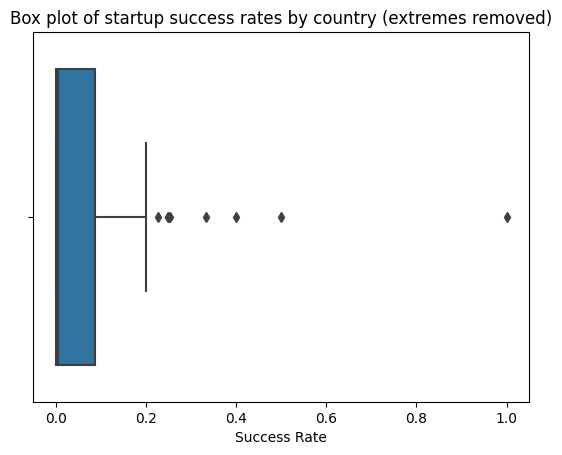

In [ ]:
sns.boxplot(x=countries["success"]).set_title('Box plot of startup success rates by country (extremes removed)')
plt.xlabel("Success Rate")

Text(0.5, 0, 'Number of Successful Startups')

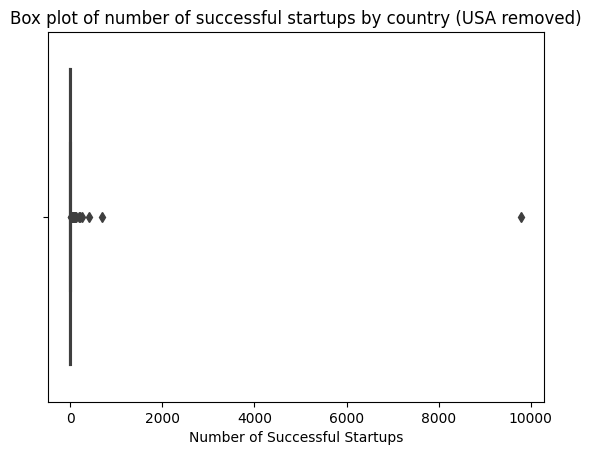

In [ ]:
sns.boxplot(x=countries2['success']).set_title('Box plot of number of successful startups by country (USA removed)')
plt.xlabel("Number of Successful Startups")

We see in both cases, the datasets are dominanted by a set of outliers. In the case of success rates, we can garner that the median success rate is somewhere in the 0.05 range, but the presence of outliers in the count of successful startups makes the boxplot difficult to interpret, and removing all the outliers would strip much of the meaning away from the visualization. To this end, we see that startups globally are dominated by a largely developed and developing countries, as these countries have the capital and safety nets to support entrepreneurs and startups more.

From this inital graphic, we can gain insight into a few main takeaways


*   Most countries around the world are not great places for startups, as many countries have low single or double digits for successful startups with very low success rates
*   However, there are many countries with relatively strong startup scenes. Among these include developed economies such as the United States and England, with also rapidly developing economies, such as India and Myanmar. Whether it is through a strong innovation economy, education, and technology sectors (such as in the case of developed economies) or due to rapid capacity for growth and improvement in developing economies, these countries are good environments for startups.
*   Globally, we see that the United States is overwhelmingly dominant in terms of absolute number of successful startups. In fact, the United States may have more successful startups than the rest of the world combined. This speaks to the important idea that the United States is a great enviornment for startups, and is something we will wish to investigate in more detail.
*   Furthermore, other developed economies also had relatively strong startup ecosystems to support an aggregate number of successful startups, such as Canada, England, Germany, and France



## 4.2 Startups in the United States

As we saw previously that the United States was far and away the country with the most number of successful startups, we want to now look at the distribution among U.S. states for rates of startup success and absolute startup numbers. This will help us identify hubs of innovation in the United States. Is California still a dominant force in the innovation economy or are other states in close competition?

In [ ]:
#perform a similar subset and drop duplicate operation
eda2 = data[['company_id', 'name', 'success', 'country_state']]
eda2 = eda2.drop_duplicates()
eda2 = eda2.dropna()

#We only keep the last two characters if the first three characters are USA, this helps us identify the US states
eda2['country_state'] = eda2['country_state'].apply(lambda x: x[3:5] if x[0:3] == "USA" else '')
#remove all other countries
eda2 = eda2[eda2.country_state != '']
#Generate the two datsets by grouping on state and aggregating
states = eda2.groupby('country_state').mean().reset_index(drop = False)
states = states.sort_values('success', ascending = False)
#to get a better absolute sense, also use:
states2 = eda2.groupby('country_state').sum().reset_index(drop = False)
states2 = states2.sort_values('success', ascending = False)

<ipython-input-11-d5fe58b48bda>:11: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-11-d5fe58b48bda>:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
fig = px.choropleth(states, locations = 'country_state',
                    locationmode="USA-states",
                    color = 'success',
                    hover_name = 'country_state',
                    scope = 'usa',
                    color_continuous_scale=px.colors.sequential.Blues,
                    title = "Startup success rate by state")
fig.show()

When we look at startup successrates, we see that California as expected is a strong location for startups. However, we also notably see that states such as Massachusetts (perhaps not too much of a suprise), Washington, Maine, West Virginia, and even Colorado also maintain high startup success rates. In fact, just these states alone would be outliers in the global stage!

Similar to before, we also want to look at absolute counts of successful startups per state.

In [ ]:
fig = px.choropleth(states2, locations = 'country_state',
                    locationmode="USA-states",
                    color = 'success',
                    hover_name = 'country_state',
                    scope = 'usa',
                    color_continuous_scale=px.colors.sequential.Turbo,
                    title = "Number of successful startups per state")
fig.show()

Here, our initial hypothesis about the state with the greatest number of startups is proven correct. California has far and away the most number of startups, though followed closely by New York and Massachusetts. In fact, if California were split off as its own 'country' for analysis in the global stage, it would come in second globally, highlighting the huge number of startups in the state. Notably, while New York has a high number of startups (close to 1,000), its startup success rate is not outstanding.

From these two graphics, we have a few main takeaways

First, let's think about the rates of success for states in the United States
*   Majority of states have around a 15 - 20% success rate for startups, which is higher than most countries in the world. This helps indicate that the United States as a whole is a very strong market for startups
*   The best states with regards to startup success mostly make sense: California, Massachusetts, Washtingon. However, there are some intersting states such as West Virginia and Colorado with relatively high success rates which are generally not known for their startup economies.
* Two areas of lower startup success include the deep South and Midwest, both of which are likely due to lower population density and less economic development from technology.

Now, thinking about the aggregate number of successful startups per state:
* California is far and away the state with the most successful startups. In fact, if California was considered as its own country, it would have the second largest number of successful startups (after the United States).
* Other states with large number of successful startups include Massachusetts, Texas, and New York.
* Of intersting note is that even states with "few" startups (such as Oregon, North Carolina, and Tennessee) have more successful startups than most other countries in the world, which just goes to emphasis how strong the environment is for startups in the United States.

However, we also get some interesting insights from combining the two graphics in tandem: noting the discrepancy between states with a high number of successful startups yet low overall success rates
* For instance, while New York has close to 1,000 startups, it's sucess rate is relatively low at around 20%
* However, states such as Colorado and Washington, with ~200 and ~400 successful startups respectively, have almost 30% success rates

This helps to indicate potential market oversaturation, potentially the startup enviornment in New York is oversaturated, or that there exists stronger ennvrionments and innovation economies in places like Washington and Colorado.


## 4.3 Startup Sector and Success

Continuing, we would like to investigate some characteristics of startups and their sectors. Having developed a spatial and geographic understanding of startup success globally, we also want to think about which industries and sectors have the most startups, the most funding, or the highest rates of success. This analysis could help potential venture capital funds or angel investors think about which industries would give the best ROI, as they could provide less startup funding but still have a high chance of startup success.

After some testing, pie charts don't really work due to the higher number of possible categories. Therefore, we have to use some other kind of visualization mechanism.

In [ ]:
#Again we subset data and drop duplicates to remove the people association
eda3 = data[['company_id', 'name', 'category_code', 'funding_total_usd', 'success']]
eda3 = eda3.drop_duplicates()

#Group by sector and sum funding totals
sectors = eda3.groupby('category_code')['funding_total_usd'].sum().reset_index(drop = False)
#Also calculate success ratios
secSuccess = eda3.groupby('category_code')['success'].mean().reset_index(drop = False)
#Then merge so we can maintain both columns
sectors = sectors.merge(secSuccess)

sectors.head()

,category_code,funding_total_usd,success
0,advertising,11722619928,0.137003
1,analytics,6344398077,0.404930
2,automotive,3534699857,0.208589
3,biotech,46964233814,0.465301
4,cleantech,26933431603,0.318103


With these two columns aggregated, we want to think about startups, sucess, and sectors along multiple dimensions. That is, which sectors have the most amount of funding and in turn, which sectors have the highest success rate?

To accomplish this, we want to use a treemap from the Plotly library, which allows us to color by success rate and make boxes that correspond to the amount of funding a sector received (in aggregate)

In [ ]:
fig = px.treemap(sectors, path = [px.Constant('all'), 'category_code'],#, 'name'],
                 values = 'funding_total_usd',
                 color = 'success',
                 color_continuous_scale='Greens',
                 title = "Startup industry funding, colored by success rate")
fig.show()

We can glean a variety of useful results from this treemap. First, we see that sectors such as biotech and software dominant global startup funding, despite the success rate of software not being that great. In fact, it seems that the top 6 sectors make up almost half of global startup funding, yet sectors such as e-commerce and software, while receiving a lot of funding, are not that successful. On the other hand, we see sectors with lower levels of aggregate funding, such as medical, semiconductor, and in particular nanotech, have extremely high levels of success. This would be a useful and quick visualization for angel investors, as it shows that they can get the best 'bang for buck' effect investing in businesses that function in sectors such as nantech and semiconductors (micro-technology).

To use a more traditional, quantiative graphic, we can also adopt a simple bar plot. However, to make the plot a little bit different, we will instead look at the number of startups rather than the aggregate value of funding raised by startups.

Text(0, 0.5, 'Number of Startups')

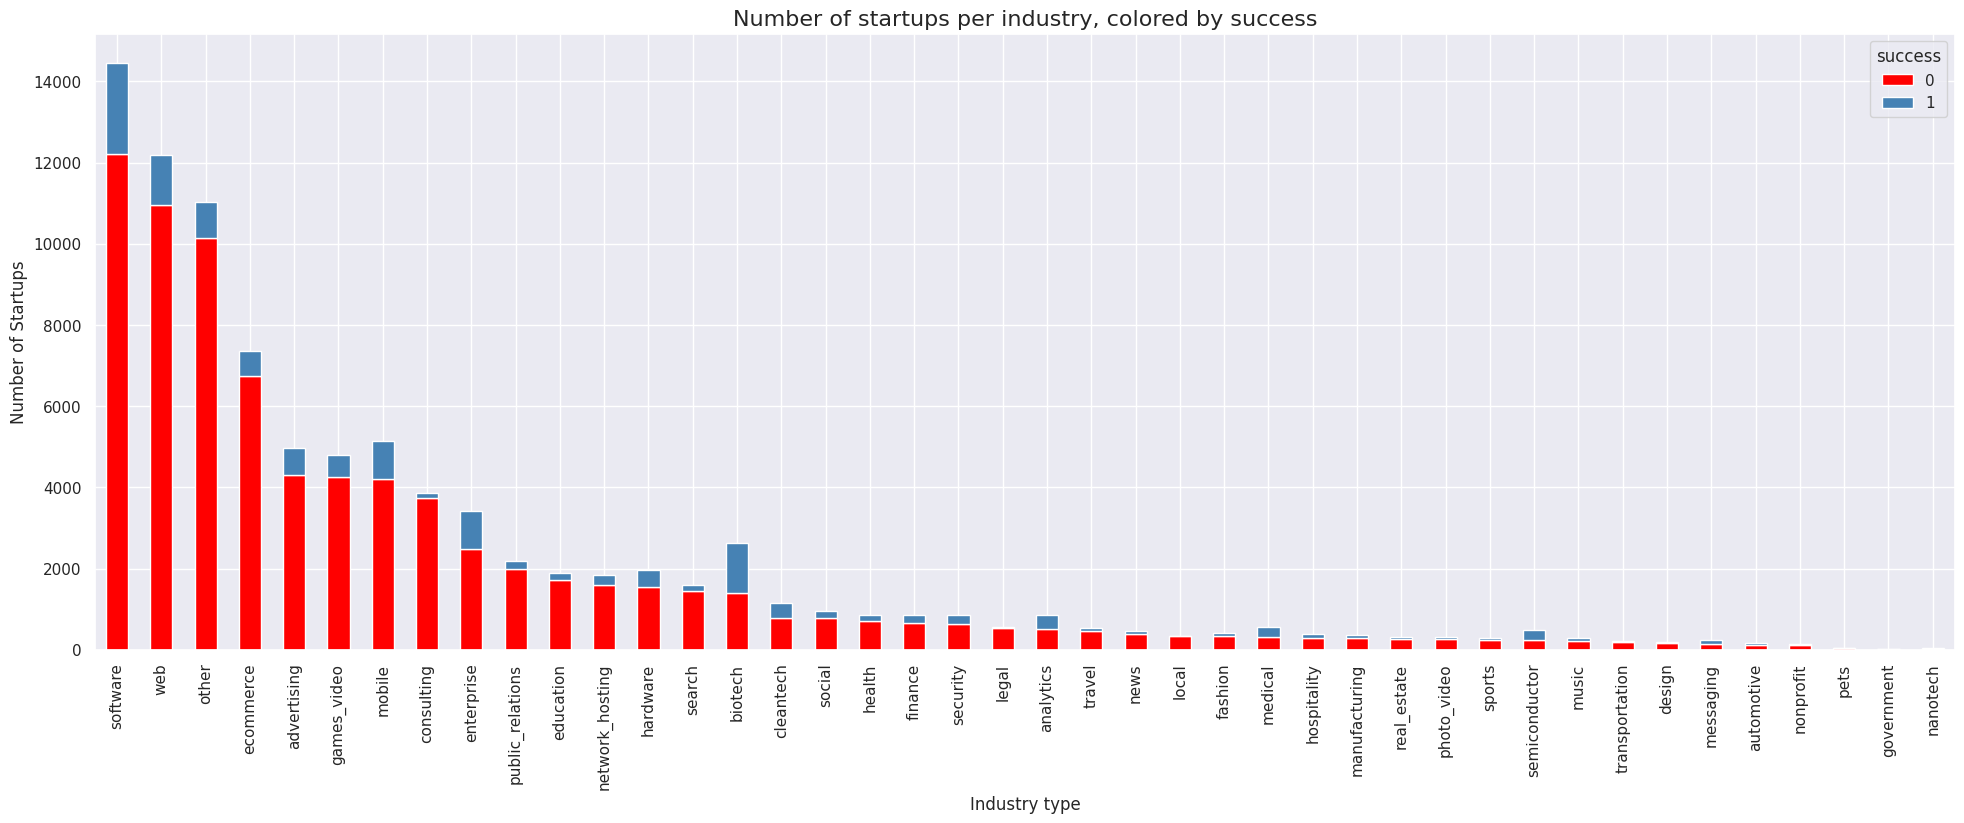

In [ ]:
#Subset columns
secBar = eda3.groupby(['category_code', 'success'])['name'].count().reset_index()
#Pivot categories out into their own columns for plotting
secBar = secBar.pivot(index = 'category_code', columns = 'success', values = 'name').reset_index()
secBar = secBar.sort_values(0, ascending = False).reset_index(drop = True)
secBar = secBar.rename(columns = {2: 'Failure', 3: 'Success'})

#set seaborn plotting aesthetics
sns.set(style='white')
sns.set(rc={"figure.figsize":(24, 8)})

#create stacked bar chart
secBar.set_index('category_code').plot(kind='bar', stacked=True, color=['red', 'steelblue'])
#add overall title
plt.title('Number of startups per industry, colored by success', fontsize=16)

#add axis titles
plt.xlabel('Industry type')
plt.ylabel('Number of Startups')

With this new visualization, we have colored the failed startups in red and the successful start ups in blue. We again notice some interesting trends. As noted previously, sectors such as biotech, medical, and semiconductor have disproportionate success rates. Yet one notable difference is that while biotech had the largest amount of aggregate funding for startups, there are actually a relatively low number of total biotech firms. For investors, this may present mixed signals. While biotech startups have very high rates of success and the industry does not seem too saturated, the capital costs for a biotech startup are very high. Continuing, we see that with regards to absolute number of startups, technology industries such as software and web still dominant, despite have much lower rates of success.

Here is a quick summary of the main takeaways from this set of graphics:
* By sector, most successful secotrs include places like semiconductors, nanotech, and biotech/medical
* When considering investor ROI and the best "bang for buck" trade, industries like semiconductors and nanotech provide a higher chance of success with relatively low funding requirements
* On the flip side, startups in areas like software, web, and ecommerce (dot-com boom style startups) tend to have lower success rates but higher funding needed

For funds, this helps give an idea of where you can best spend your investing capital. For founds and those interested in startups, this helps give you an idea of which markets are potentially oversatured, and which ones will have large VC capital flows directed towards them in the future.

## 4.4 Funding rounds and success

Having looked into aggregations of sector and funding, this leads us to another interesting question: does a company which receives many rounds of funding typically succeed? Or, in other words, are investors and Venture Capital firms smart about providing firms with multiple rounds of investment? How does a company's total amount of funding relate to the number of rounds of funding it received (this should be a strong positive correlation) and in turn to the success and failure thereof of those companies?

In [ ]:
#subset and drop duplicates
eda4 = data[['company_id', 'name', 'category_code', 'country_state', 'funding_total_usd', 'funding_rounds', 'success']]
eda4 = eda4.drop_duplicates()
#drop blank countries and push into 3-letter codes
eda4 = eda4.dropna(subset = 'country_state')
eda4['country_state'] = eda4['country_state'].apply(lambda x: x[0:3])
eda4 = eda4[eda4.funding_total_usd > 0]

[Text(0.5, 1.0, 'Rounds of funding by total amount raised, colored by success'),
 Text(0.5, 0, 'Number of rounds of funding'),
 Text(0, 0.5, 'Total amount raised (USD)')]

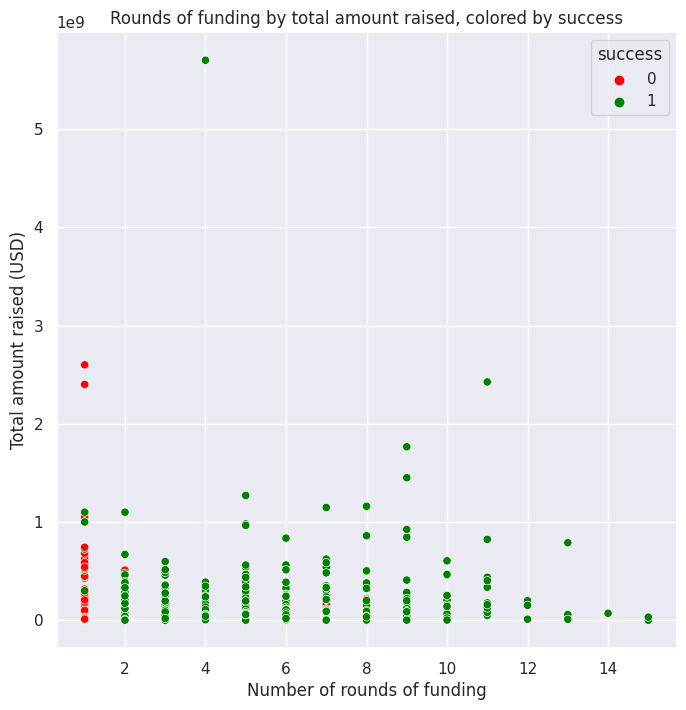

In [ ]:
#Set up graphic aesthetics
palette = {1: "green",
           0: "red"}
sns.set(rc={"figure.figsize":(8, 8)})
#Create the scatterplot
ax = sns.scatterplot(data = eda4, x = "funding_rounds", y = "funding_total_usd", hue = "success", palette = palette)
ax.set(title = "Rounds of funding by total amount raised, colored by success",
       xlabel = 'Number of rounds of funding',
       ylabel = 'Total amount raised (USD)')

From this graphic, we see that broadly speaking, VC firms are able to identify successful startups and provide them with appropriate funding. This is because we see that there are very few red dots (failures) above two rounds of funding. One interest feature here though is that the total amount raised does not necessairly go up as rounds of funding goes up. While one would expect that a company would get more total funding over more rounds of funding, there is no such relationship. We see that the company with the most funding actually had four rounds of funding, while many companies with additional large funding amounts had anywhere from 1 to 11 rounds of funding.

Continuing, we want to look at this graphic but subsetted to specifically the United States.

[Text(0.5, 1.0, 'Rounds of funding by total amount raised, colored by success (US startups)'),
 Text(0.5, 0, 'Number of rounds of funding'),
 Text(0, 0.5, 'Total amount raised (USD)')]

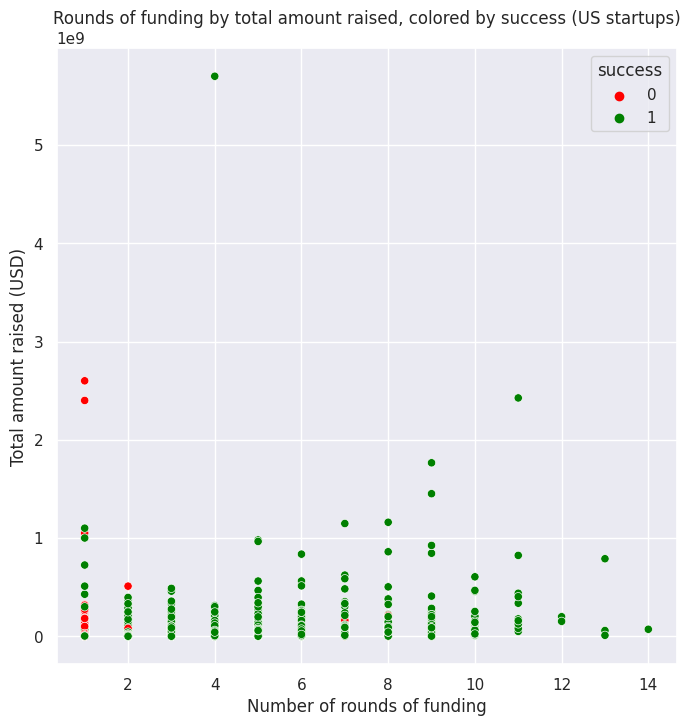

In [ ]:
#Subset the data
usaeda4 = eda4[eda4.country_state == 'USA']
#make the scatterplot
ax = sns.scatterplot(data = usaeda4, x = "funding_rounds", y = "funding_total_usd", hue = "success", palette = palette)
ax.set(title = "Rounds of funding by total amount raised, colored by success (US startups)",
       xlabel = 'Number of rounds of funding',
       ylabel = 'Total amount raised (USD)')

Interestingly, we don't actually see too much of a change in the distribution of the graphic. Notably, many of the failed startups after one round of funding are gone, though most of the startups that received more than $1B in USD of funding remain. This suggests that the U.S. has a strong scene for Venture Capital, as many investors and funds have a lot of money to invest.

A brief summary of the takeaways from these two graphics

* Few failures (red dots) are observed above two rounds of funding.
* Total funding does not necessarily increase as rounds of funding go up.
* The company with the most funding had four rounds, while others had 1 to 11 rounds
* Few failures after 1 round of startup funding (most additional funding rounds done by VC's or private investors are accurate in being able to gauge a company's future performance)
* The United States maintains a strong Venture Capital scene capable of providing massive amounts of funding for startups

## 4.5 Countries and Status

Where we have previously looked at countries and rates of success, as well as countries and absolute success counts, we are interest in a more nuanced view as well. In particular, we want to think about how startups in different countries fare generally. Are most startups in certain countries still operating? Are there any countries that generally conduct more IPOs or acquisitions than other countries?

Note that we did have to filter down our dataset a bit, removing all countries with 10 or less startups, as otherwise the number of countries would have made the visualization unreadable.

In [ ]:
#Standard subset, duplicate removal, and country letter code cleanup
eda5 = data[['company_id', 'name', 'status', 'country_state', 'success']]
eda5 = eda5.drop_duplicates()
eda5 = eda5.dropna(subset = 'country_state')
eda5['country_state'] = eda5['country_state'].apply(lambda x: x[0:3])

#Group by country and sort by status
opBar = eda5.groupby(['country_state', 'status'])['name'].count().reset_index()
opBar = opBar.pivot(index = 'country_state', columns = 'status', values = 'name').reset_index()
opBar = opBar.sort_values('operating', ascending = False).reset_index(drop = True)

#need to filter because otherwise plot is unreadable
opBar = opBar[opBar.operating > 10]

#set seaborn plotting aesthetics
sns.set(style='white')
sns.set(rc={"figure.figsize":(24, 8)})

#create stacked bar chart
opBar.set_index('country_state').plot(kind='bar', stacked=True)
#add overall title
plt.title('Number of startups per country, colored by status', fontsize=16)

#add axis titles
plt.xlabel('Country (>10 operating startups)')
plt.ylabel('Number of Startups')

Text(0, 0.5, 'Number of Startups')

As expected, we see that the United States is dominating the global startup market. It has a strong acquisitions and IPO market, but also has many more failures than other countries. Despite this, the majority of its startups are remaining in the operational stage. Notably, the U.S. maintains the highest proportion of acquiried companies out of other countries, which indicates that not only is there a strong startup scene, but the U.S. also has many other large companies in a more mature stage that will buy up startups.

Continuing, we want to also remove the U.S. from the visualization to gain a better idea of global trends in startup status.

Text(0, 0.5, 'Number of Startups')

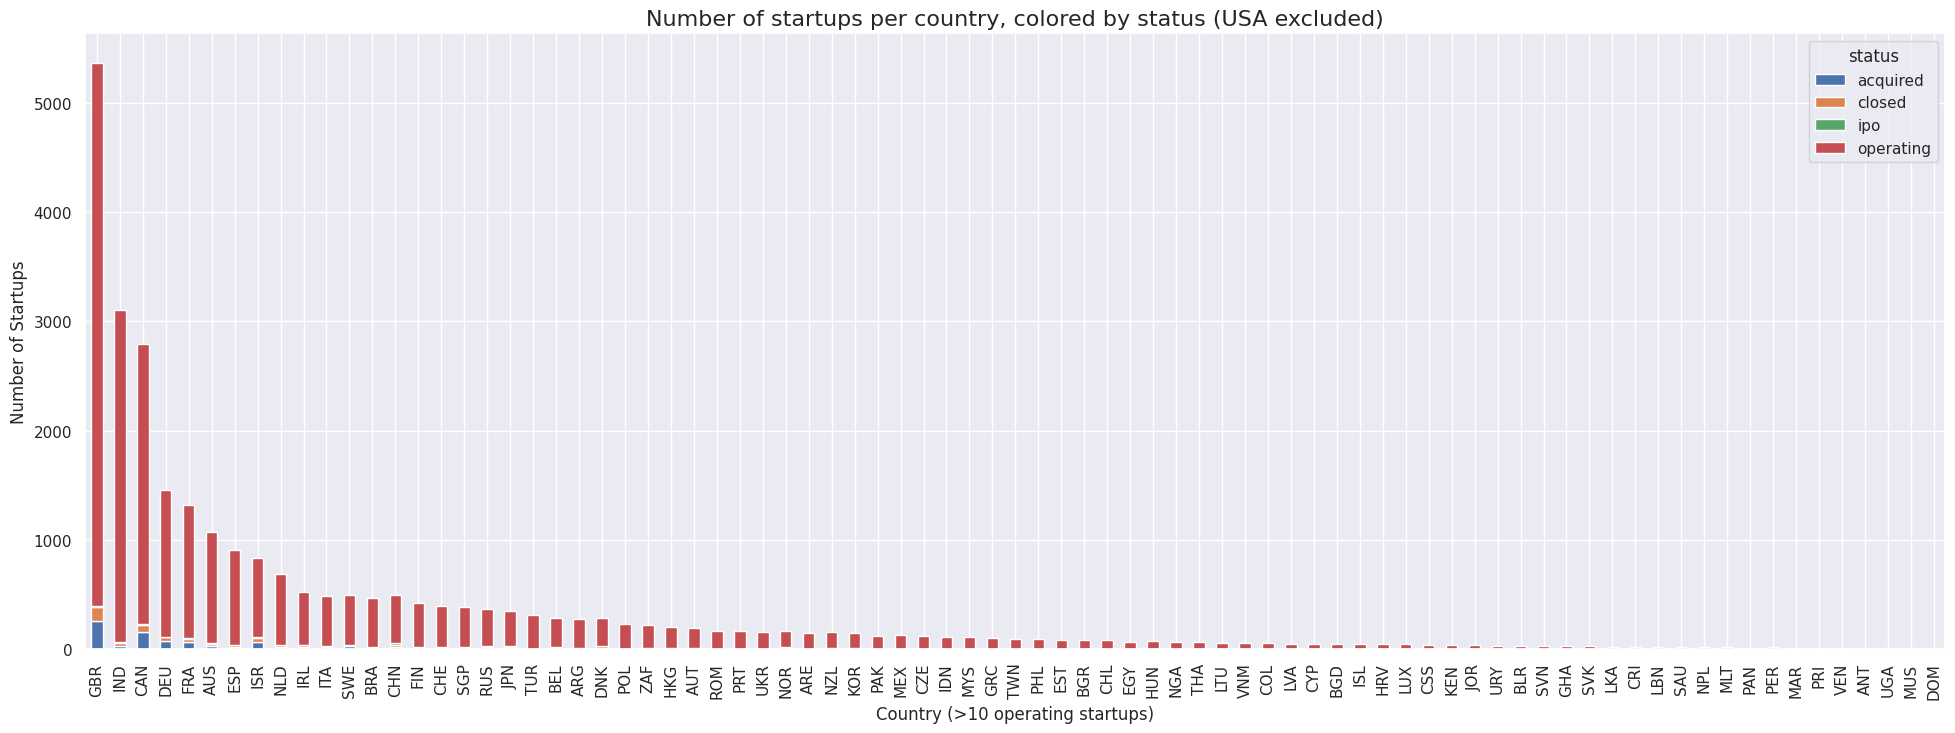

In [ ]:
#remove the U.S.
opBar2 = opBar[opBar.country_state != 'USA']
#create stacked bar chart
opBar2.set_index('country_state').plot(kind='bar', stacked=True)
#add overall title
plt.title('Number of startups per country, colored by status (USA excluded)', fontsize=16)

#add axis titles
plt.xlabel('Country (>10 operating startups)')
plt.ylabel('Number of Startups')

After removing the U.S., we see that the remaining top countries for total number of startups is England, India, and Canada. Notably, while England and Canada have strong acquisitions numbers, most Indian startups are still in the operating stage. This makes some sense, as England and Canada are more developed countries, while India is still a developing economy. Notably, we also see Israel as another country with a large number of acquisitions.

# Part 5: Feature Engineering

## 5.1 Further Data Cleaning

As a continuation from data cleaning and EDA, we conduct further data processing to narrow down the samples and features that will be used for modeling.

In our final dataset, each sample is a company, and each feature is a potential factor that may contribute to the success of a company.

First of all, we read the cleaned data for EDA and drop the unnecessary data for modeling.

In [ ]:
# load cleaned data
df = pd.read_csv('mainData.csv')

In [ ]:
# drop the columns that are unused in feature engineering or modeling
df = df.drop(['name', 'status', 'country_state', 'funding_rounds', 'liquidity_success', 'operating_success', 'person_object_id', 'first_name', 'last_name'], axis=1)

In [ ]:
# we use 'country_code' and 'degree_type' columns in the feature engineering stage, so we drop any sample that does not have data for these 2 columns.
df = df[df['country_code'].notna() & df['degree_type'].notna()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245221 entries, 0 to 297533
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   company_id                245221 non-null  object 
 1   category_code             245221 non-null  object 
 2   founded_at                245221 non-null  object 
 3   tag_list                  158191 non-null  object 
 4   country_code              245221 non-null  object 
 5   funding_total_usd         245221 non-null  float64
 6   relationships             245221 non-null  int64  
 7   founded_during_recession  245221 non-null  int64  
 8   success                   245221 non-null  int64  
 9   is_past                   245221 non-null  float64
 10  degree_type               245221 non-null  object 
 11  subject                   245221 non-null  object 
 12  institution               245221 non-null  object 
 13  graduated_at              245221 non-null  o

Each row in the current dataframe represents a person-subject pair, but our main goal is to predict the success of a company, so we need to group by companies.

In [ ]:
df = df.groupby('company_id').agg({
    'category_code': 'first',                   # 'category_code' is the same for all rows of each company, so we just take the first value.
    'founded_at': 'first',                      # 'founded_at' is the same for all rows of each company, so we just take the first value.
    'tag_list': 'first',                        # 'tag_list' is the same for all rows of each company, so we just take the first value.
    'country_code': 'first',                    # 'country_code' is the same for all rows of each company, so we just take the first value.
    'funding_total_usd': 'first',               # 'funding_total_usd' is the same for all rows of each company, so we just take the first value.
    'relationships': 'first',                   # 'relationships' is the same for all rows of each company, so we just take the first value.
    'founded_during_recession': 'first',        # 'founded_during_recession' is the same for all rows of each company, so we just take the first value.
    'success': 'first',                         # 'success' is the same for all rows of each company, so we just take the first value.
    'is_past': 'sum',                           # 'is_past' is specific for each person in the company, so we sum it up to calculate the total number of key people who have left the company.
    'degree_type': list,                        # 'degree_type' is specific for each person in the company, so we accumulate them to check the overall degree types of key people of each company.
    'subject': list                             # 'subject' is specific for each person in the company, so we accumulate them to check the overall college majors of key people of each company.
}).reset_index()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49785 entries, 0 to 49784
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_id                49785 non-null  object 
 1   category_code             49785 non-null  object 
 2   founded_at                49785 non-null  object 
 3   tag_list                  35111 non-null  object 
 4   country_code              49785 non-null  object 
 5   funding_total_usd         49785 non-null  float64
 6   relationships             49785 non-null  int64  
 7   founded_during_recession  49785 non-null  int64  
 8   success                   49785 non-null  int64  
 9   is_past                   49785 non-null  float64
 10  degree_type               49785 non-null  object 
 11  subject                   49785 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.6+ MB


Now we have an intermediate dataset where each row is a company and each column is useful for generating features in the feature engineering section. However, before getting to feature engineering, there is an issue that we need to tackle.

## 5.2 Features

We convert the columns of the intermediate dataset into the following 10 features:
- **category_code**: The industry category of each company.
- **tag_list_len**: The number of tags each company possesses in its online presence.
- **funding_total_usd**: The total amount of fundings each company received.
- **relationships**: The number of key people in each company at the record time.
- **country_code**: The country where each company is in.
- **founded_during_recession**: Whether each company was founded in recession. (if founded in recession, 1; otherwise, 0)
- **is_past**: The number of key people who have left each company at the record time.
- **n_days**: The number of days between the record date (i.e., 2013-12-01) and the founding date of each company.
- **degree_ratio**: The ratio of advanced degree (i.e., non-Bachelor's degrees) holders among the key people in each company.
- **stem_ratio**: The ratio of STEM degree (i.e., Science, Technology, Engineering, Mathematics) holders among the key people in each company.

The choice, functionality, and processing of each feature is discussed separately below.

### 5.2.1 category_code

Category code indicates which industry the company is in. We believe that this feature has a direct impact on the success of a company, because different industries faced different macroeconomic influences during this time period. In any arbitrary time period, some industries suffer relatively more financial damage than others, and some industries thrive relatively more than others. This feature intends to capture such industry-specific macroeconomic factors.

There are a total of 42 categories of the selected company samples.

In [ ]:
len(df['category_code'].unique())

42

We process this categorical variable into 42 columns through one-hot encoding.

In [ ]:
df = df.join(pd.get_dummies(df['category_code']))

### 5.2.2 tag_list_len

The number of tags that the company possesses on the internet is a great indicator of the company's public exposure. We believe that the more tags a company has, the more exposure this company has in terms of online presence. Exposure is an indicator of success for 2 logical reasons. First, it indicates that the company has enough budgets for online marketing, indicating a healthy financial situation of the company during that period. Second, it indicates a higher range of potential customers with the knowledge of this company's existence, hinting a potentially higher revenue that the company receives through its goods and services. This is an integer variable.

In [ ]:
def get_len(row):
    return len(row['tag_list'].split()) if type(row['tag_list']) == str else 0

df['tag_list_len'] = df.apply(lambda x: get_len(x), axis=1)

### 5.2.3 funding_total_usd

The total amount of fundings that a company obtained by the recording time should be a straightforward key factor of its success. It not only determines the financial situation of the company directly but also indicates VC's confidence in the company's future performance. VCs have far more information about the companies they invest in than us, given the datasets we have. Therefore, when VCs confidently invest in a company, it indirectly tells us that this company is judged as a potentially successful company by financial professionals. This is an integer variable.

In [ ]:
# no need to modify anything

### 5.2.4 relationships

The number of key people associated with a company indicates the size of the company and may be an interesting indicator of the company's success. While the size does not necessarily determine the success rate of a company, larger companies tend to have more confidence and less variability to various external events and therefore are more likely to survive successfully. This is an integer variable.

In [ ]:
# no need to modify anything

### 5.2.5 country_code

The country where this company is founded at should capture nation-specific macroeconomic impacts that the company faces during this time period, thus included in the features. As discussed in EDA, some countries, especially USA, have significantly better startup atmospheres compared to other countries where startups are rare, such as (???). While this does not necessarily determine the success of a company, this does determine the amount of regional externalities that the company receives.

There are a total of 141 countries of the selected company samples.

In [ ]:
len(df['country_code'].unique())

141

We process this categorical variable into 141 columns through one-hot encoding.

In [ ]:
df = df.join(pd.get_dummies(df['country_code']))

### 5.2.6 founded_during_recession

Whether the company was founded during recession could be a potential indicator of the company's success. The fact that the founders had the courage to found the company during recession says a lot about their potentials. However, at the same time, recession may also be a huge drawback factor for this company to survive. This is a integer (0/1) variable, where 1 indicates it is founded during recession and 0 indicates otherwise.

In [ ]:
# no need to modify anything

### 5.2.7 is_past

While "relationships" captures the number of key people associated with the company at the time the data was recorded, "is_past" captures the number of key people who left the company at the time the data was recorded. This is an important indicator of the company's operating situation and potentials. Although there could be many reasons that cause key employees to leave, if many left, the company may not be doing a good job. This is an integer variable.

In [ ]:
# no need to modify anything

### 5.2.8 n_days

The number of days between the company's founding day and the day the data was recorded simply indicates the lifespan of the company. The data was recorded by Crunchbase in December 2013, so we set the record date as '2013-12-01'. We do not expect a monotonic relationship here but rather interested in seeing how the 2008 financial crisis impacted the companies' performances. Were companies founded before it able to survive? Were companies founded during and after it able to thrive? These are the information that may potentially be captured by the lifespan of the company. This is an integer variable.

In [ ]:
df['founded_at'] = pd.to_datetime(df['founded_at'])
df['n_days'] = (datetime.strptime('2013-12-01','%Y-%m-%d')-df['founded_at']).dt.days

### 5.2.9 degree_ratio

We want to see the ratio of advanced degree holders among the key people in each company, but the "degree_type" column of the original data is extremely messy and unstructured. Since we are absolutely not allowed to do any NLP for this project, our best bet is to count the ratio of people with degrees that start with the letter 'b' (which indicates bachelor) and subtract it from 1 as the ratio of people with non-bachelor degrees, indicating an advanced degree instead. While graduate degrees do not directly indicate the success of a company since there are exceptional cases where college dropouts created some of the most successful companies in the real world, we still believe that people with advanced degrees may possess more knowledge and skills compared to undergraduate degree holders. This is a float variable between 0 and 1.

In [ ]:
def get_degree_ratio(row):
    total, bachelors = 0,0
    for deg in row['degree_type']:
        if deg != 'unknown':
            total += 1
            if deg[0].lower() == 'b':
                bachelors += 1
    return 1-bachelors/total if total else 0

df['degree_ratio'] = df.apply(lambda x: get_degree_ratio(x), axis=1)

### 5.2.10 stem_ratio

Similarly, we want to see the ratio of STEM majors among the key people in each company, but the "subject" column is even trickier to deal with. Again, since we cannot use NLP techniques, our best bet is to check if any of the 4 indicators of a STEM major exists in the subject string: 'engineer', 'compu', 'math', 'tech'. Even 'science' cannot be used as 'political science' and 'social science' exist. We calculate the ratio in a similar way as "degree_ratio". While STEM is not necessarily an indicator of a company's success, we are just curious to see if we the engineers can drive startup success. This is a float variable between 0 and 1.

In [ ]:
def get_stem_ratio(row):
    total, stems = 0,0
    stem = ('engineer', 'compu', 'math', 'tech')
    for sub in row['subject']:
        if sub != 'unknown':
            total += 1
            for key in stem:
                if key in sub:
                    stems += 1
                    break
    return 1-stems/total if total else 0

df['stem_ratio'] = df.apply(lambda x: get_stem_ratio(x), axis=1)

We drop the excessive columns that are unused in modeling, and we finally have a concrete dataframe with 8 feature columns (+183 one-hot-encoded feature columns) and the target label column.

In [ ]:
df = df.drop(['company_id', 'tag_list', 'category_code', 'country_code', 'founded_at', 'degree_type', 'subject'], axis=1)

In [ ]:
df.to_csv('features.csv', index=False, encoding='utf-8')

## 5.3 EDA on features

Wish our features engineer, we want to conduct some EDA to look at basic relationships among our new features. We will start with a correlation matrix encoded in a heatmap so we can visualize all of these relationships at once. Note that previously we did one-hot encoding on many of our categorical variables, we will need to subset our columns down to a realistic set to make our EDA visually digestable and not overloaded.

In [ ]:
df = pd.read_csv('features.csv')
df = df[['n_days', 'degree_ratio', 'stem_ratio', 'tag_list_len', 'success', 'relationships', 'funding_total_usd', 'founded_during_recession']]

Following this subset, we will import seaborn to create an annotated haetmap to display the relationships among our columns of interest. Of particular note is the relationship between a given variable and success, as well as any strong relationships among other variables, as this may give us some insight into later dimension-reduction.

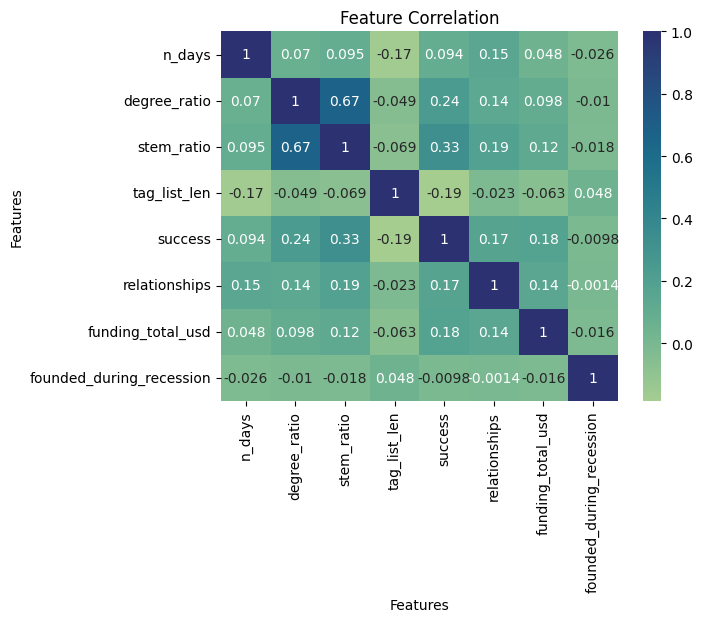

In [ ]:
dataplot = sns.heatmap(df.corr(), cmap = 'crest', annot = True)
plt.title("Feature Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

As expected, the diagonal row is complete 1s. However, there are a few interesting correlations of note. Degree ratio and success, as well as stem ratio and success, and stem ratio and degree ratio, have relatively "strong" (strong relative to other correlation values) correlations. This suggests, particularly in the case of stem ratio to degree ratio, that most individuals in a startup have STEM degrees, and that there exists some (but not a strong) relationship between the type of degree received and a startups success. Moreover, the more important takeaway here is that many of our variables of interest have low correlation values with others, which is good because it indicates our variables are not related or influencing each other significantly (in the case of degree ratio and stem ratio, some relation may be inevitable due to the nature of the variables in question).

## 5.4 Class Imbalance

As shown in the graph below, we have a significant class imbalance in our dataset, where the number of successful companies (11451) is significantly lower than the number of failed companies (38334). This class imbalance would cause our models to be strongly biased in favor of the "failure" class and lead to poor predictive performances.

In [ ]:
X = df.drop('success', axis=1)  # features
y = df['success']               # labels

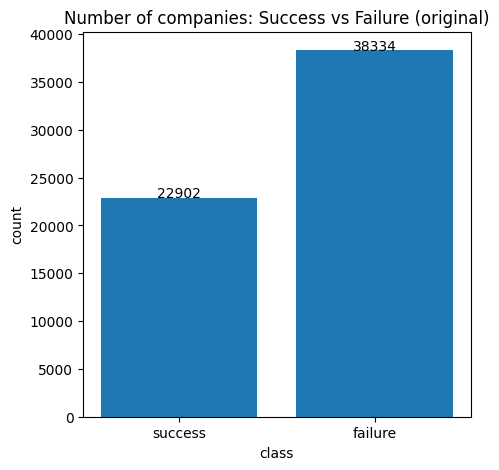

In [ ]:
plt.figure(figsize=(5,5))
bars = [len(y[y==1]), len(y[y==0])]
plt.bar(['success', 'failure'], bars)
plt.text(0, bars[0], bars[0], ha='center')
plt.text(1, bars[1], bars[1], ha='center')
plt.title('Number of companies: Success vs Failure (original)')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

There are 2 major strategies to tackle the issue of class imbalance:
- oversample the minority class (i.e., success)
- undersample the majority class (i.e., failure)

We will choose the oversampling strategy only because we do not want to lose the available information about failure companies. Specifically, we will use **SMOTE (Synthetic Minority Oversampling Technique)** for this purpose. To initiate the process, SMOTE randomly picks an instance from the minority class and identifies its k nearest neighbors within the same class. Subsequently, a synthetic instance is generated by randomly selecting one neighbor from the k nearest neighbors and connecting points to create a line segment in the feature space. The resulting synthetic instances are produced as convex combinations of the two selected instances.

In [ ]:
X, y = SMOTE().fit_resample(X, y)

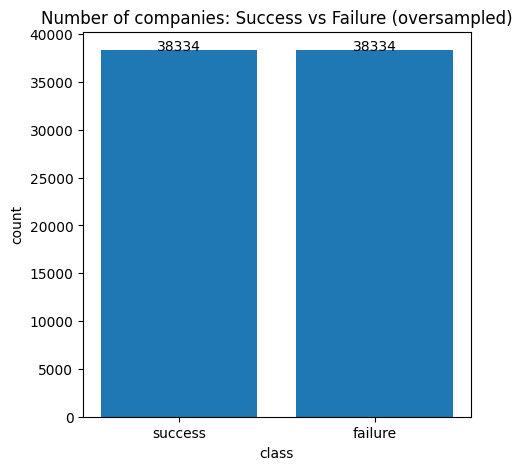

In [ ]:
plt.figure(figsize=(5,5))
bars = [len(y[y==1]), len(y[y==0])]
plt.bar(['success', 'failure'], bars)
plt.text(0, bars[0], bars[0], ha='center')
plt.text(1, bars[1], bars[1], ha='center')
plt.title('Number of companies: Success vs Failure (oversampled)')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

Now we have a fully balanced dataset and can keep going.

## 5.5 Dimensionality Reduction

A crucial issue with one-hot-encoding, especially when the number of values of a category is large, is that we end up with a huge sparse feature matrix. In our case, "category_code" and "country_code" led to high sparsity in our feature space.

If we assume equal feature importance among the 10 features, we would definitely want to reduce the dimensionality of the one-hot-encoded features to emphasize on the feature importance of the remaining 8 numerical features.

Therefore, we define 3 sets of features to work with:
- Raw, unreduced features
- Fully reduced features via PCA
- Partially reduced features via PCA

For each model, we experiment with all 3 sets during hyperparameter tuning and choose the set that maximizes the tuning objective as our final dataset for modeling and evaluation. Basically, the choice of dimensionality reduction can be considered as a hyperparameter that is tuned during the tuning stage.

### 5.5.1 Train-test split

We do train-test split with a 0.8:0.2 ratio on raw features and keep them for further processing and experiments.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### 5.5.2 Full reduction via PCA

We use PCA (Principal Component Analysis), the most commonly used unsupervised learning method for dimensionality reduction on features, to reduce all of our features.

In [ ]:
# standard scaling
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

# pca
pca = PCA()
pca.fit(X_train_transformed)

PCA()

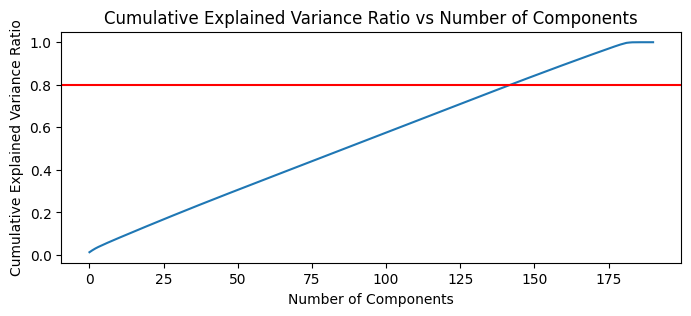

In [ ]:
cum_evr = [sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]

plt.figure(figsize=(8,3))
plt.plot(cum_evr)
plt.axhline(y=0.8, color='r')
plt.title("Cumulative Explained Variance Ratio vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

There are far too many components due to the number of one-hot-encoded columns. For simplicity, we stick to 140 principal components, which explain nearly 80% of the variance in the feature space.

In [ ]:
# pca
pca = PCA(n_components=140)
pca.fit(X_train_transformed)

# transform
X_train_pca = pca.transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

### 5.5.3 Partial reduction via PCA

If we assume a near-equal feature importance among the 10 features, we would want to keep the 8 numerical features and simply reduce the dimensionality of the sparse one-hot-encoded features. This is exactly what partial reduction does.

The 8 numerical features that we keep are listed here:

In [ ]:
noreduce_columns = ["tag_list_len", "funding_total_usd", "relationships", "founded_during_recession", "is_past", "n_days", "degree_ratio", "stem_ratio"]

In [ ]:
X_train_noreduce = X_train[noreduce_columns]
X_test_noreduce = X_test[noreduce_columns]
X_train_reduce = X_train.drop(noreduce_columns, axis=1)
X_test_reduce = X_test.drop(noreduce_columns, axis=1)

We standardize both "noreduce" and "reduce" features separately, and we only perform PCA on the "reduce" features.

In [ ]:
# standard scaling
scaler = StandardScaler()
X_train_noreduce_transformed = scaler.fit_transform(X_train_noreduce)
X_test_noreduce_transformed = scaler.transform(X_test_noreduce)

scaler = StandardScaler()
X_train_reduce_transformed = scaler.fit_transform(X_train_reduce)
X_test_reduce_transformed = scaler.transform(X_test_reduce)

# pca
pca = PCA()
pca.fit(X_train_reduce_transformed)

PCA()

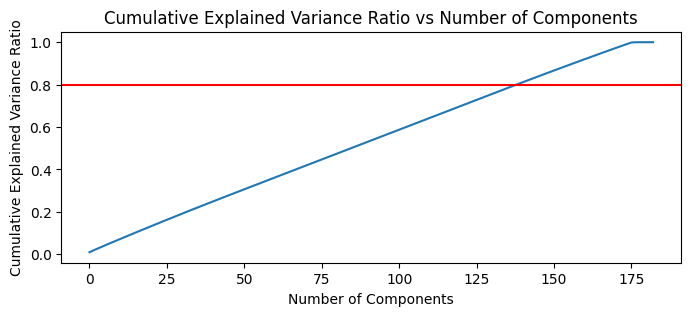

In [ ]:
cum_evr = [sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]

plt.figure(figsize=(8,3))
plt.plot(cum_evr)
plt.axhline(y=0.8, color='r')
plt.title("Cumulative Explained Variance Ratio vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

Once again, there are far too many components due to the sparse feature matrix, we use 137 components for the one-hot-encoded features.

In [ ]:
# pca
pca = PCA(n_components=137)
pca.fit(X_train_reduce_transformed)

# transform
X_train_pca_partial = np.concatenate((X_train_noreduce_transformed, pca.transform(X_train_reduce_transformed)), axis=1)
X_test_pca_partial = np.concatenate((X_test_noreduce_transformed, pca.transform(X_test_reduce_transformed)), axis=1)

As a summary of what we have got so far, here is a report:

In [ ]:
print("Shape of original features:")
print("X_train: ", X_train_transformed.shape)
print("X_test:  ", X_test_transformed.shape)
print()
print("Shape of full PCA-reduced features:")
print("X_train: ", X_train_pca.shape)
print("X_test:  ", X_test_pca.shape)
print()
print("Shape of partial PCA-reduced features:")
print("X_train: ", X_train_pca_partial.shape)
print("X_test:  ", X_test_pca_partial.shape)

Shape of original features:
X_train:  (61334, 191)
X_test:   (15334, 191)

Shape of full PCA-reduced features:
X_train:  (61334, 140)
X_test:   (15334, 140)

Shape of partial PCA-reduced features:
X_train:  (61334, 145)
X_test:   (15334, 145)


# Part 6: Modeling

3 different classification models are used in this project:
- **Logistic Regression** (Baseline)
- **LightGBM**
- **Neural Network**

We would like to emphasize on the different model type choices we have here. Logistic regression is a linear model, LightGBM is a gradient boosting model, and neural networks are neural networks. Linear models are mostly suitable as baseline choices due to their simplicity. Gradient boosting models are the second most complex type of machine learning models which perform exceptionally well for tabular data in terms of accuracy. Neural networks, while being extremely effective on computer vision and natural language processing, are not necessary the best models when it comes to tabular data. Therefore, we make these 3 choices on the model types to validate these presumptions. The choice of each specific model is explained in each subsection separately.

Each model is experimented on the aforementioned 3 feature sets, each labeled as a subsection as follows:
- **Naive ver.**: raw, unreduced features
- **Full PCA ver.**: fully-reduced features via PCA
- **Partial PCA ver.**: partially-reduced features via PCA

We run hyperparameter tuning for each model separately, and we choose the optimal hyperparameters together with the feature set that maximize test accuracy. The choice of hyperparameter grids are explained in each section separately.

## 6.1 Logistic Regression (Baseline)

Logistic regression - the simplest linear classification model - is often considered the most suitable baseline model for classification problems due to its simplicity, interpretability, and effectiveness in a variety of scenarios. Logistic regression provides probabilities of each predicted class, making it easy to understand and interpret the results. Its computational efficiency and scalability also contribute to its popularity as a baseline model. While logistic regression may not capture complex relationships as effectively as more advanced classification models, it serves as a reliable starting point, helping us establish a benchmark for performance and paving the way for more sophisticated models when necessary.

We select the following hyperparameters to tune:
- **penalty**: The regularization hyperparameter. 'None' means no regularization, and 'l1' and 'l2' means L1 and L2 regularizations respectively. Regularization is used to prevent overfitting, and L1 regularization performs additional feature selection by converting the weights of certain features to 0, which may be useful when we have quite many sparse features.
- **fit_intercept**: Whether or not to add a bias to the model. A bias may not have much influence on the model in our case due to the number of sparse features we have, but it is a good hyperparameter to tune.

In [ ]:
param_grid = {
    'penalty': [None, 'l1', 'l2'],
    'fit_intercept': [True, False]
}

pgrid = ParameterGrid(param_grid)

### Naive ver.

In [ ]:
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # l1 requires a different solver
    solver = 'liblinear' if params['penalty'] == 'l1' else 'lbfgs'

    # train model
    clf = LogisticRegression(penalty=params['penalty'], fit_intercept=params['fit_intercept'], solver=solver)
    clf.fit(X_train_transformed, y_train)

    # check test accuracy
    curr_test_acc = clf.score(X_test_transformed, y_test)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for Logistic Regression (naive): ", best_params)

Best hyperparameters for Logistic Regression (naive):  {'fit_intercept': False, 'penalty': None}


In [ ]:
# obtain accuracies with the best hyperparameters
solver = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
clf = LogisticRegression(penalty=best_params['penalty'], fit_intercept=best_params['fit_intercept'], solver=solver)
clf.fit(X_train_transformed, y_train)

print("Train accuracy for Logistic Regression (naive): ", clf.score(X_train_transformed, y_train))
print("Test accuracy for Logistic Regression (naive):  ", clf.score(X_test_transformed, y_test))

Train accuracy for Logistic Regression (naive):  0.8089640329996413
Test accuracy for Logistic Regression (naive):   0.8091169949132646


### Full PCA ver.

In [ ]:
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # l1 requires a different solver
    solver = 'liblinear' if params['penalty'] == 'l1' else 'lbfgs'

    # train model
    clf = LogisticRegression(penalty=params['penalty'], fit_intercept=params['fit_intercept'], solver=solver)
    clf.fit(X_train_pca, y_train)

    # check test accuracy
    curr_test_acc = clf.score(X_test_pca, y_test)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for Logistic Regression (full PCA): ", best_params)

Best hyperparameters for Logistic Regression (full PCA):  {'fit_intercept': True, 'penalty': None}


In [ ]:
# obtain accuracies with the best hyperparameters
solver = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
clf = LogisticRegression(penalty=best_params['penalty'], fit_intercept=best_params['fit_intercept'], solver=solver)
clf.fit(X_train_pca, y_train)

print("Train accuracy for Logistic Regression (full PCA): ", clf.score(X_train_pca, y_train))
print("Test accuracy for Logistic Regression (full PCA):  ", clf.score(X_test_pca, y_test))

Train accuracy for Logistic Regression (full PCA):  0.7366061238464799
Test accuracy for Logistic Regression (full PCA):   0.7295552367288379


### Partial PCA ver.

In [ ]:
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # l1 requires a different solver
    solver = 'liblinear' if params['penalty'] == 'l1' else 'lbfgs'

    # train model
    clf = LogisticRegression(penalty=params['penalty'], fit_intercept=params['fit_intercept'], solver=solver)
    clf.fit(X_train_pca_partial, y_train)

    # check test accuracy
    curr_test_acc = clf.score(X_test_pca_partial, y_test)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for Logistic Regression (partial PCA): ", best_params)

Best hyperparameters for Logistic Regression (partial PCA):  {'fit_intercept': True, 'penalty': 'l2'}


In [ ]:
# obtain accuracies with the best hyperparameters
solver = 'liblinear' if best_params['penalty'] == 'l1' else 'lbfgs'
clf = LogisticRegression(penalty=best_params['penalty'], fit_intercept=best_params['fit_intercept'], solver=solver)
clf.fit(X_train_pca_partial, y_train)

print("Train accuracy for Logistic Regression (partial PCA): ", clf.score(X_train_pca_partial, y_train))
print("Test accuracy for Logistic Regression (partial PCA):  ", clf.score(X_test_pca_partial, y_test))

Train accuracy for Logistic Regression (partial PCA):  0.7610786839273486
Test accuracy for Logistic Regression (partial PCA):   0.7546628407460545


### Summary

In summary, given our selection of feature engineering and hyperparameter tuning, the best possible Logistic Regression model we can achieve is with the following setting:

- **Features**: raw
- **Hyperparameters**: {'fit_intercept': False, 'penalty': None}
- **Training accuracy**: 0.8089640329996413
- **Test accuracy**: 0.8091169949132646

In [ ]:
# use the overall best combinations of features and hyperparameters for the best model to be evaluated later
clf_logreg = LogisticRegression(penalty=None, fit_intercept=False)
clf_logreg.fit(X_train_transformed, y_train)

LogisticRegression(fit_intercept=False, penalty=None)

## 6.2 LightGBM

LightGBM (Light Gradient-Boosting Machine) is the state-of-the-art gradient tree boosting framework designed for efficient and distributed machine learning. It stands out for its high performance and scalability, making it particularly effective for large datasets. In classification problems, LightGBM builds an ensemble of decision trees, optimizing the model's predictive accuracy. It uses a leaf-wise tree growth strategy and employs a histogram-based approach for feature discretization, reducing memory usage and speeding up training. LightGBM also supports categorical features without requiring one-hot encoding. Its key parameters include the number of boosting rounds, learning rate, and tree depth. By leveraging these features, LightGBM provides a powerful tool for achieving accurate and fast classification results in various applications.

There are lots of hyperparameters for LightGBM. Due to time constraints, we will only select 4 of them to tune, each of which serves a different function according to the official LightGBM guide: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html:

- **num_iterations**: controls how many trees are grown during training.
- **max_depth**: controls how deep each tree in the ensemble is, where deeper trees may lead to overfitting.
- **feature_fraction**: controls how many features are randomly selected before constructing each tree, which in turn reduces the total number of splits that have to be evaluated to add each tree node.
- **bagging_fraction**: controls how many samples are randomly selected before constructing each tree, which in turns serves as a regularization method and reduces training time if it is small.

In addition to tuning these hyperparameters, we manually set the training **objective** to be binary classification and the **learning_rate** to be 0.01 because it is a pretty standard learning rate, not too fast or too slow.

In [ ]:
param_grid = {
    "num_iterations": [100, 300, 500],
    'max_depth': [2,4,6],
    "feature_fraction": [0.2, 0.5, 1],
    "bagging_fraction": [0.2, 0.5, 1]
}

pgrid = ParameterGrid(param_grid)

### Naive ver.

In [ ]:
# fix some hyperparameters for LightGBM
lgb_params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'seed': seed
}
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # add selected hyperparameters to LightGBM hyperparameter dictionary
    for k,v in params.items():
        lgb_params[k] = v
    lgb_params['num_leaves'] = 2**lgb_params['max_depth']   # num_leaves is required to be 2^max_depth

    # train model
    clf = LGBMClassifier(**lgb_params)
    clf.fit(X_train_transformed, y_train)

    # check test accuracy
    y_pred = clf.predict(X_test_transformed)
    curr_test_acc = accuracy_score(y_test, y_pred)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for LightGBM (naive): ", best_params)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# obtain accuracies with the best hyperparameters
for k,v in best_params.items():
    lgb_params[k] = v
lgb_params['num_leaves'] = 2**lgb_params['max_depth']
clf = LGBMClassifier(**lgb_params)
clf.fit(X_train_transformed, y_train)
y_pred_train = clf.predict(X_train_transformed)
y_pred_test = clf.predict(X_test_transformed)

print("Train accuracy for LightGBM (naive): ", accuracy_score(y_train, y_pred_train))
print("Test accuracy for LightGBM (naive):  ", accuracy_score(y_test, y_pred_test))

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Info] Number of positive: 30680, number of negative: 30654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1740
[LightGBM] [Info] Number of data points in the train set: 61334, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500212 -> initscore=0.000848
[LightGBM] [Info] Star

### Full PCA ver.

In [ ]:
# fix some hyperparameters for LightGBM
lgb_params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'seed': seed
}
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # add selected hyperparameters to LightGBM hyperparameter dictionary
    for k,v in params.items():
        lgb_params[k] = v
    lgb_params['num_leaves'] = 2**lgb_params['max_depth']   # num_leaves is required to be 2^max_depth

    # train model
    clf = LGBMClassifier(**lgb_params)
    clf.fit(X_train_pca, y_train)

    # check test accuracy
    y_pred = clf.predict(X_test_pca)
    curr_test_acc = accuracy_score(y_test, y_pred)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for LightGBM (full PCA): ", best_params)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# obtain accuracies with the best hyperparameters
for k,v in best_params.items():
    lgb_params[k] = v
lgb_params['num_leaves'] = 2**lgb_params['max_depth']
clf = LGBMClassifier(**lgb_params)
clf.fit(X_train_pca, y_train)
y_pred_train = clf.predict(X_train_pca)
y_pred_test = clf.predict(X_test_pca)

print("Train accuracy for LightGBM (full PCA): ", accuracy_score(y_train, y_pred_train))
print("Test accuracy for LightGBM (full PCA):  ", accuracy_score(y_test, y_pred_test))

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Info] Number of positive: 30680, number of negative: 30654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35700
[LightGBM] [Info] Number of data points in the train set: 61334, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500212 -> initscore=0.000848
[LightGBM] [Info] Start training from score 0.000848
[LightGBM] [Warning] No further 

### Partial PCA ver.

In [ ]:
# fix some hyperparameters for LightGBM
lgb_params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'seed': seed
}
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # add selected hyperparameters to LightGBM hyperparameter dictionary
    for k,v in params.items():
        lgb_params[k] = v
    lgb_params['num_leaves'] = 2**lgb_params['max_depth']   # num_leaves is required to be 2^max_depth

    # train model
    clf = LGBMClassifier(**lgb_params)
    clf.fit(X_train_pca_partial, y_train)

    # check test accuracy
    y_pred = clf.predict(X_test_pca_partial)
    curr_test_acc = accuracy_score(y_test, y_pred)
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for LightGBM (partial PCA): ", best_params)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 30680, number of negative: 30654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36360
[LightGBM] [Info] Number of data points in the train set: 61334, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500212 -> initscore=0.000848
[LightGBM] [Info] Start training from score 0.000848
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current v

In [ ]:
# obtain accuracies with the best hyperparameters
for k,v in best_params.items():
    lgb_params[k] = v
lgb_params['num_leaves'] = 2**lgb_params['max_depth']
clf = LGBMClassifier(**lgb_params)
clf.fit(X_train_pca_partial, y_train)
y_pred_train = clf.predict(X_train_pca_partial)
y_pred_test = clf.predict(X_test_pca_partial)

print("Train accuracy for LightGBM (partial PCA): ", accuracy_score(y_train, y_pred_train))
print("Test accuracy for LightGBM (partial PCA):  ", accuracy_score(y_test, y_pred_test))

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Info] Number of positive: 30680, number of negative: 30654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36360
[LightGBM] [Info] Number of data points in the train set: 61334, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500212 -> initscore=0.000848
[LightGBM] [Info] Sta

### Summary

In summary, given our selection of feature engineering and hyperparameter tuning, the best possible LightGBM model we can achieve is with the following setting:

- **Features**: partial PCA
- **Hyperparameters**: {'bagging_fraction': 0.2, 'feature_fraction': 1, 'max_depth': 6, 'num_iterations': 500}
- **Training accuracy**: 0.8761372158998272
- **Test accuracy**: 0.8633102908569192

In [ ]:
# use the overall best combinations of features and hyperparameters for the best model to be evaluated later
lgb_params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'seed': seed,
    'bagging_fraction': 0.2,
    'feature_fraction': 1,
    'max_depth': 6,
    'num_iterations': 500
}
lgb_params['num_leaves'] = 2**lgb_params['max_depth']
clf_lgb = LGBMClassifier(**lgb_params)
clf_lgb.fit(X_train_pca_partial, y_train)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Info] Number of positive: 30680, number of negative: 30654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36360
[LightGBM] [Info] Number of data points in the train set: 61334, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500212 -> initscore=0.000848
[LightGBM] [Info] Start training from score 0.000848
[LightGBM] [Warning] No further 

LGBMClassifier(bagging_fraction=0.2, feature_fraction=1, learning_rate=0.01,
               max_depth=6, num_iterations=500, num_leaves=64,
               objective='binary', seed=2)

## 6.3 Neural Networks

Following the rapid development of big data and computational resources, neural networks stand out as the exceptionally powerful tools for classification problems. The hierarchical structure of neural networks, composed of interconnected layers of artificial neurons, enables them to capture intricate patterns and relationships within the data. During training, neural networks update their parameters to minimize the difference between predicted and actual outputs, effectively learning to generalize from examples. This adaptability allows neural networks to handle complex and non-linear decision boundaries, making them well-suited for tasks where the relationship between inputs and outputs is intricate and not easily defined by simple rules. While they are widely used for computer vision and natural language processing, they may not always be the best choice for small, tabular datasets due to their huge computational complexity.

Just like gradient tree boosting models, a neural network can have tons of hyperparameters to tune, and it takes a significantly longer time to train a fully-connected neural network compared to the previous two models. In this project, we only use linear layers, together with ReLU activations and dropout layers in between. ReLU is the most widely used activation option due to its simplicity and effectiveness in tackling the notorious vanishing gradient problem in deep learning, and dropout layers can effectively prevent overfitting by randomly getting rid of certain neurons in training. There is no need to use convolutional layers or recurrent layers as no image or sequential data is involved. Therefore, we will only tune the following hyperparameters:
- **Number of layers**: number of linear-activation blocks in the NN, including the input block and the output block
- **Number of neurons per hidden layer**: number of neurons per hidden layer
- **Dropout**: whether to add dropout layers at the end of each block (excluding output block). We are not going to tune the dropout probability due to time constraints.

Due to time constraints, we use 5 epochs for training during hyperparameter tuning. Once we obtain the best hyperparameters for each feature set, we use 10 epochs for training to obtain the best performance of the neural network given the best hyperparameters.

In [ ]:
param_grid = {
    "n_layers": [2, 3, 4],
    "hidden_size": [16, 48, 128],
    "dropout": [True, False]
}
pgrid = ParameterGrid(param_grid)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Naive ver.

In [ ]:
# set up dataloaders with selected features
batch = 64
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train_transformed), torch.Tensor(y_train.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test_transformed), torch.Tensor(y_test.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)

In [ ]:
# build FNN model
class FNN(nn.Module):
    def __init__(self, params):
        super().__init__()
        # input layer
        self.fnn = nn.Sequential(
            nn.Linear(X_train_transformed.shape[1], params['hidden_size']),
            nn.ReLU()
        )
        # add dropout if needed
        if params['dropout']:
            self.fnn.append(nn.Dropout())

        # hidden layers
        for _ in range(params['n_layers']-2):
            self.fnn.append(nn.Linear(params['hidden_size'], params['hidden_size']))
            self.fnn.append(nn.ReLU())
            if params['dropout']:
                self.fnn.append(nn.Dropout())

        # output layer
        self.fnn.append(nn.Linear(params['hidden_size'], 2))

    def forward(self, x):
        return self.fnn(x)

In [ ]:
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # init model, criterion, and optimizer
    fnn = FNN(params=params).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fnn.parameters())

    # train model
    for epoch in range(5):
        for inputs, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = fnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # run test predictions
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fnn(inputs)
            preds = torch.argmax(outputs, 1)
            correct += torch.sum(preds==labels.data)
            total += labels.size(0)

    # check test accuracy
    curr_test_acc = correct/total
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for NN (naive): ", best_params)

Best hyperparameters for NN (naive):  {'dropout': False, 'hidden_size': 48, 'n_layers': 3}


In [ ]:
# obtain accuracies with the best hyperparameters (same as above)
fnn = FNN(params=best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters())

# train with 10 epochs instead of 5
for epoch in range(10):
    total,correct = 0,0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = fnn(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if epoch == 9:
            total += labels.size(0)
            correct += torch.sum(preds==labels.data)
            train_acc = correct/total

# test
total,correct = 0,0
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = fnn(inputs)
        preds = torch.argmax(outputs, 1)
        correct += torch.sum(preds==labels.data)
        total += labels.size(0)
test_acc = correct/total

print("Train accuracy for NN (naive): ", train_acc.item())
print("Test accuracy for NN (naive):  ", test_acc.item())

Train accuracy for NN (naive):  0.8422082662582397
Test accuracy for NN (naive):   0.8340941667556763


### Full PCA ver.

In [ ]:
# set up dataloaders with selected features
batch = 64
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train_pca), torch.Tensor(y_train.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test_pca), torch.Tensor(y_test.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)

In [ ]:
# build FNN model
class FNN(nn.Module):
    def __init__(self, params):
        super().__init__()
        # input layer
        self.fnn = nn.Sequential(
            nn.Linear(X_train_pca.shape[1], params['hidden_size']),
            nn.ReLU()
        )
        # add dropout if needed
        if params['dropout']:
            self.fnn.append(nn.Dropout())

        # hidden layers
        for _ in range(params['n_layers']-2):
            self.fnn.append(nn.Linear(params['hidden_size'], params['hidden_size']))
            self.fnn.append(nn.ReLU())
            if params['dropout']:
                self.fnn.append(nn.Dropout())

        # output layer
        self.fnn.append(nn.Linear(params['hidden_size'], 2))

    def forward(self, x):
        return self.fnn(x)

In [ ]:
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # init model, criterion, and optimizer
    fnn = FNN(params=params).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fnn.parameters())

    # train model
    for epoch in range(5):
        for inputs, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = fnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # run test predictions
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fnn(inputs)
            preds = torch.argmax(outputs, 1)
            correct += torch.sum(preds==labels.data)
            total += labels.size(0)

    # check test accuracy
    curr_test_acc = correct/total
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for NN (Full PCA): ", best_params)

Best hyperparameters for NN (Full PCA):  {'dropout': False, 'hidden_size': 48, 'n_layers': 4}


In [ ]:
# obtain accuracies with the best hyperparameters (same as above)
fnn = FNN(params=best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters())

# train with 10 epochs instead of 5
for epoch in range(10):
    total,correct = 0,0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = fnn(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if epoch == 9:
            total += labels.size(0)
            correct += torch.sum(preds==labels.data)
            train_acc = correct/total

# test
total,correct = 0,0
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = fnn(inputs)
        preds = torch.argmax(outputs, 1)
        correct += torch.sum(preds==labels.data)
        total += labels.size(0)
test_acc = correct/total

print("Train accuracy for NN (Full PCA): ", train_acc.item())
print("Test accuracy for NN (Full PCA):  ", test_acc.item())

Train accuracy for NN (Full PCA):  0.8160889744758606
Test accuracy for NN (Full PCA):   0.8109429478645325


### Partial PCA ver.

In [ ]:
# set up dataloaders with selected features
batch = 64
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train_pca_partial), torch.Tensor(y_train.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test_pca_partial), torch.Tensor(y_test.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)

In [ ]:
# build FNN model
class FNN(nn.Module):
    def __init__(self, params):
        super().__init__()
        # input layer
        self.fnn = nn.Sequential(
            nn.Linear(X_train_pca_partial.shape[1], params['hidden_size']),
            nn.ReLU()
        )
        # add dropout if needed
        if params['dropout']:
            self.fnn.append(nn.Dropout())

        # hidden layers
        for _ in range(params['n_layers']-2):
            self.fnn.append(nn.Linear(params['hidden_size'], params['hidden_size']))
            self.fnn.append(nn.ReLU())
            if params['dropout']:
                self.fnn.append(nn.Dropout())

        # output layer
        self.fnn.append(nn.Linear(params['hidden_size'], 2))

    def forward(self, x):
        return self.fnn(x)

In [ ]:
max_test_acc, best_params = 0, None

for params in list(pgrid):
    # init model, criterion, and optimizer
    fnn = FNN(params=params).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fnn.parameters())

    # train model
    for epoch in range(5):
        for inputs, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = fnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # run test predictions
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fnn(inputs)
            preds = torch.argmax(outputs, 1)
            correct += torch.sum(preds==labels.data)
            total += labels.size(0)

    # check test accuracy
    curr_test_acc = correct/total
    if max_test_acc < curr_test_acc:
        max_test_acc, best_params = curr_test_acc, params

print("Best hyperparameters for NN (Partial PCA): ", best_params)

Best hyperparameters for NN (Partial PCA):  {'dropout': False, 'hidden_size': 128, 'n_layers': 3}


In [ ]:
# obtain accuracies with the best hyperparameters (same as above)
fnn = FNN(params=best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fnn.parameters())

# train with 10 epochs instead of 5
for epoch in range(10):
    total,correct = 0,0
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = fnn(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if epoch == 9:
            total += labels.size(0)
            correct += torch.sum(preds==labels.data)
            train_acc = correct/total

# test
total,correct = 0,0
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = fnn(inputs)
        preds = torch.argmax(outputs, 1)
        correct += torch.sum(preds==labels.data)
        total += labels.size(0)
test_acc = correct/total

print("Train accuracy for NN (Partial PCA): ", train_acc.item())
print("Test accuracy for NN (Partial PCA):  ", test_acc.item())

Train accuracy for NN (Partial PCA):  0.8403984904289246
Test accuracy for NN (Partial PCA):   0.8282900452613831


### Summary

In summary, given our selection of feature engineering and hyperparameter tuning, the best possible Neural Network model we can achieve is with the following setting:

- **Features**: raw
- **Hyperparameters**: {'dropout': False, 'hidden_size': 48, 'n_layers': 3}
- **Training accuracy**: 0.8422082662582397
- **Test accuracy**: 0.8340941667556763

In [ ]:
# use the overall best combinations of features and hyperparameters for the best model to be evaluated later
batch = 64
train_loader = DataLoader(
    TensorDataset(torch.Tensor(X_train_transformed), torch.Tensor(y_train.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)
test_loader = DataLoader(
    TensorDataset(torch.Tensor(X_test_transformed), torch.Tensor(y_test.to_numpy())),
    batch_size=batch,
    shuffle=False,
    num_workers=0
)

# build best model structure with raw unreduced features
class FNN(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.fnn = nn.Sequential(
            nn.Linear(X_train_transformed.shape[1], params['hidden_size']),
            nn.ReLU()
        )
        if params['dropout']:
            self.fnn.append(nn.Dropout())
        for _ in range(params['n_layers']-2):
            self.fnn.append(nn.Linear(params['hidden_size'], params['hidden_size']))
            self.fnn.append(nn.ReLU())
            if params['dropout']:
                self.fnn.append(nn.Dropout())
        self.fnn.append(nn.Linear(params['hidden_size'], 2))

    def forward(self, x):
        return self.fnn(x)

clf_fnn = FNN(params={'dropout': False, 'hidden_size': 48, 'n_layers': 3}).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_fnn.parameters())

# train the best FNN model
for epoch in range(10):
    for inputs, labels in train_loader:
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = clf_fnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Part 7: Evaluation

Now that we have the best possible version of each model based on test accuracy, we conduct a thorough binary classification evaluation with each model. We present the confusion matrix together with precision/recall/F1-scores for each model separately, and we discuss their meanings in the "Discussion" section.

Here are the summaries of the 3 models with the best hyperparameter combinations:

In [ ]:
clf_logreg

LogisticRegression(fit_intercept=False, penalty=None)

In [ ]:
clf_lgb

LGBMClassifier(bagging_fraction=0.2, feature_fraction=1, learning_rate=0.01,
               max_depth=6, num_iterations=500, num_leaves=64,
               objective='binary', seed=2)

In [ ]:
clf_fnn

FNN(
  (fnn): Sequential(
    (0): Linear(in_features=191, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=2, bias=True)
  )
)

## 7.1 Logistic Regression

In [ ]:
# the best logreg was achieved with raw, unreduced features
y_pred = clf_logreg.predict(X_test_transformed)
cm_log = confusion_matrix(y_test, y_pred)

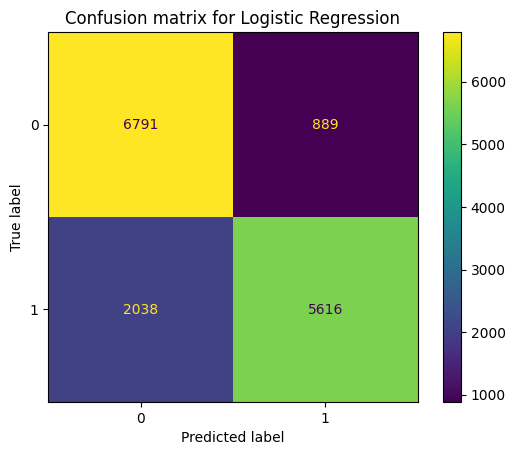

In [ ]:
ConfusionMatrixDisplay(cm_log, display_labels=[0,1]).plot()
plt.title('Confusion matrix for Logistic Regression')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['failure', 'success']))

              precision    recall  f1-score   support

     failure       0.77      0.88      0.82      7680
     success       0.86      0.73      0.79      7654

    accuracy                           0.81     15334
   macro avg       0.82      0.81      0.81     15334
weighted avg       0.82      0.81      0.81     15334



## 7.2 LightGBM

In [ ]:
# the best LightGBM was achieved with partially reduced PCA features
y_pred = clf_lgb.predict(X_test_pca_partial)
cm_lgb = confusion_matrix(y_test, y_pred)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2


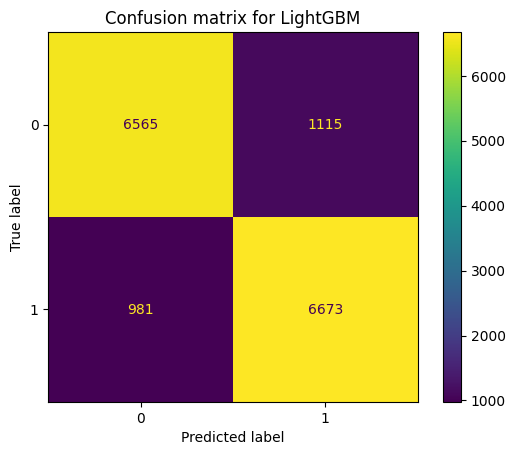

In [ ]:
ConfusionMatrixDisplay(cm_lgb, display_labels=[0,1]).plot()
plt.title('Confusion matrix for LightGBM')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['failure', 'success']))

              precision    recall  f1-score   support

     failure       0.87      0.85      0.86      7680
     success       0.86      0.87      0.86      7654

    accuracy                           0.86     15334
   macro avg       0.86      0.86      0.86     15334
weighted avg       0.86      0.86      0.86     15334



## 7.3 Neural Network

In [ ]:
# the best FNN was achieved with raw, unreduced features
y_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = clf_fnn(inputs)
        preds = torch.argmax(outputs, 1)
        y_pred.append(preds.cpu().detach().numpy())
y_pred = np.concatenate(y_pred)
cm_fnn = confusion_matrix(y_test, y_pred)

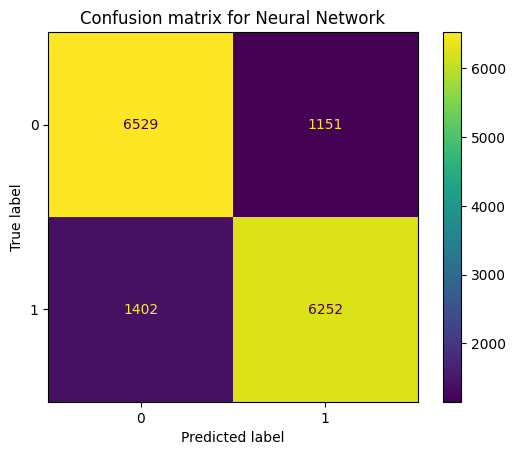

In [ ]:
ConfusionMatrixDisplay(cm_fnn, display_labels=[0,1]).plot()
plt.title('Confusion matrix for Neural Network')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['failure', 'success']))

              precision    recall  f1-score   support

     failure       0.82      0.85      0.84      7680
     success       0.84      0.82      0.83      7654

    accuracy                           0.83     15334
   macro avg       0.83      0.83      0.83     15334
weighted avg       0.83      0.83      0.83     15334



## 7.4 Discussion

Based on the confusion matrices, LogReg was best at predicting the failure companies, while LightGBM was best at predicting the success companies. However, LogReg was significantly bad at predicting success companies and therefore may not be considered a good alternative.

Here is a summary of the classification metrics in the reports above with a specific focus on the "success" label prediction:

|           | LogReg | LightGBM | FNN  |
|:----------|:------:|:--------:|:----:|
| Accuracy  | 0.81   | **0.86**     | 0.83 |
| Precision (S) | **0.86**   | **0.86**     | 0.84 |
| Recall (S)    | 0.73   | **0.87**     | 0.82 |
| F1-score (S) | 0.79   | **0.86**     | 0.83 |
| Precision (F) | 0.77   | **0.87**     | 0.82 |
| Recall (F)    | **0.88**   | 0.85     | 0.85 |
| F1-score (F) | 0.82   | **0.86**     | 0.84 |

In terms of all metrics, LightGBM dominates the performance and proves to be a better alternative on tabular data compared to neural networks. Specifically, we like to see that LightGBM was able to reach a significantly higher recall on "success" companies (0.87) compared to other models.

We would like to consider the meaning of these metrics in our problem setting, from the perspective of VCs (i.e., Venture Capitalists). Due to the core concept of loss aversion in behavioral economics, VCs are more likely to prefer missing a money-making opportunity to losing money in a failing startup, because earning nothing is better than losing money.
- **Precision**: Precision is the ratio of true positives to the total predicted positives. In our problem setting, it measures how many of the predicted successful startups were actually successful. VCs might prioritize precision because it reflects the accuracy of positive predictions. False positives in this context would mean investing in a startup that ultimately fails, resulting in financial losses for the VC. Therefore, a high precision which minimizes false positives aligns with the goal of avoiding losses. From the perspective of loss aversion, we believe this is the most important metric for VCs. While both LogReg and LightGBM achieved high precision, note that LogReg has a much lower precision for failure (0.77), meaning that it is relatively bad at capturing the true failure startups among the predicted failing startups. This is not what the VCs would like to see and therefore should be avoided at all cost. LightGBM, with a precision for failure of 0.87, is a much better option for VCs.
- **Recall**: Recall is the ratio of true positives to the total actual positives. In our problem setting, it measures how many of the true successful startups were predicted. From the perspective of loss aversion, we might not actually care much about a high recall for success unless the VC has a high degree of regret aversion, meaning that they would not want to miss out on a great investment opportunity.A high recall for failure means many of the true failure startups were predicted, and most VCs would prefer that due to the fear of losing money. While LogReg has the highest recall for failure, its extremely low precision for failure makes it not a good model for VCs to make investment decisions.
- **F1-score**: F1-score is a balance between precision and recall and provides a comprehensive view of the model's performance. It helps in finding a trade-off that aligns with the risk tolerance and preferences of VCs. For both successful and failing startups, LightGBM achieved the highest F1 scores and therefore should be considered the overall best model to use for startup success/failure predictions.

# Part 8: Conclusion
We cleaned and processed the VC startup dataset from Crunchbase in 2013. We formulate the target variable - whether a startup is a success or failure - based on their liquidity success and operating success. We engineered 10 features in total, 2 of which are categorical variables which were further processed through one-hot encoding. We acquired 3 different feature sets based on different usages of PCA. We ran 3 models (LogReg, LightGBM, FNN) on top of them, acquired the best set of hyperparameters for each of them, and evaluated their performances. LightGBM with features partially reduced by PCAperformed the best on most classification metrics, and we believe that VCs should consider using LightGBM both in terms of gaining most profits in successful startups and avoiding losses in failing startups.

**Challenges:**

* Data integration across multiple files posed challenges, demanding robust strategies to join and understand data flows (i.e what each obs meant)
* Null-processing required meticulous approaches, enhancing data reliability
* Addressing class imbalance involved techniques for accurate representation

In retrospect, each of these challenges presented unique opportunities for growth and learning, ultimately contributing to the refinement and enhancement of our data analysis capabilities.


**Limitations:**
* One limitation of this project is the inherent idea that many startups occur and succeed without venture capital funding, as they can do things like seek a loan from the bank or just have the startup capital
* Another limitation is that developing countries had less data, though it is doubtless that there are many innovations going on in those places. However, it is primarily because there is no reporting infrastructure in place that would help us better understand the environment of those places
* Additionally, the dataset and models were skewed by the United States, which domianted global successes and the dataset overall.

**Future work:**
* Future work should look into merging data regarding financial KPIs (Key Performance Indicators) to get a better economic and business-sense of these starutps
* Future work should include more geographic analysis and coverage of developing regions like the Asia-Pacific and Africa
* Future work could alter the scale and specificy of the analysis. Instead of looking at the starutps globally, it could choose a specific country, state, sector, or any combination thereof (one interesting question would be to look at variations amoung dominant sectors acround the world)
* Future work could look at the investments of individual VC firms
* Future work could look into graph-like relationships among people and firms, tracking seriel entreprenuers and the flow of people between startups.

Thank you!




